In [1]:
import numpy as np
import pandas as pd
import psutil
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-05-13 16:39:05.095387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747143545.115586   49239 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747143545.121461   49239 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747143545.136247   49239 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747143545.136282   49239 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747143545.136286   49239 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
data_5000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    with open('results_5000_mc.txt', 'a') as file:
        file.write(f"{name}: {_dict}")
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/5000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/5000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        data_5000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(data_5000).transpose().to_dict()
    with open('results_5000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_5000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_5000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model.predict(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_5000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
39995,36.155368,28633.7,7.1,116.9,10.558204,10.558204,0.0,0.0,0.0,0.0,...,356.197567,140.6,1.666013e+08,13.5,22.344181,504.642883,1.280880e+05,1.0,244.6,Bruteforce
39996,436.989332,2014.3,5.5,62.9,16.392893,16.392893,0.0,0.0,0.0,0.0,...,3.023964,69.2,2.420115e-03,5.5,11.581493,4.276530,3.052958e+01,0.3,38.5,Bruteforce
39997,0.218856,3889.2,5.4,106.5,27.824803,27.824803,0.0,0.0,0.0,0.0,...,778.624312,686.5,1.712120e-02,5.5,29.905248,1101.141062,9.659848e+05,0.9,38.5,Bruteforce
39998,63.663335,1715.2,11.5,96.8,4.135345,4.135345,0.0,0.0,0.0,0.0,...,108.960070,109.9,1.666013e+08,13.5,19.310294,153.970479,1.187418e+04,1.0,244.6,Bruteforce
39999,28.865871,48128.0,8.2,105.4,30.624000,30.624000,0.0,0.0,0.0,0.0,...,1407.994664,831.1,1.666013e+08,13.5,35.234034,1996.814533,2.011423e+06,1.0,244.6,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0              DDoS
1              DDoS
2              DDoS
3              DDoS
4              DDoS
            ...    
39995    Bruteforce
39996    Bruteforce
39997    Bruteforce
39998    Bruteforce
39999    Bruteforce
Name: Attack Type, Length: 40000, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((34000, 46), (34000,), (6000, 46), (6000,))

In [16]:
# Unique train values
unique, counts = np.unique(y_train, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 4244
1: 4257
2: 4243
3: 4266
4: 4239
5: 4279
6: 4241
7: 4231


In [17]:
# Unique train values
unique, counts = np.unique(y_test, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 756
1: 743
2: 757
3: 734
4: 761
5: 721
6: 759
7: 769


# K Nearest Neighbour

In [18]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 1.67 s, sys: 13.9 ms, total: 1.69 s
Wall time: 508 ms


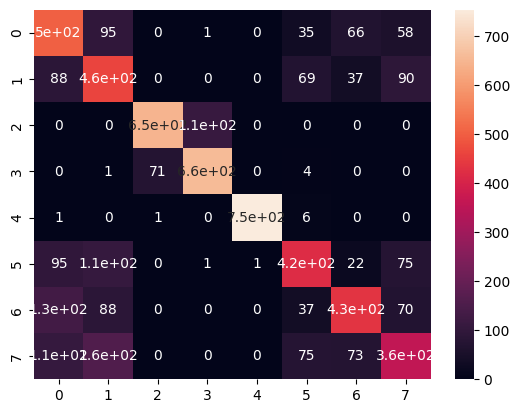

In [19]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [20]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [21]:
latency, cpu_usage = measure_latency_cpu_usage(knn_clf, X_test)

In [22]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, KNN_time]
results_dict["kNN"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [23]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.7395,2.395725,0.352871,0.507992


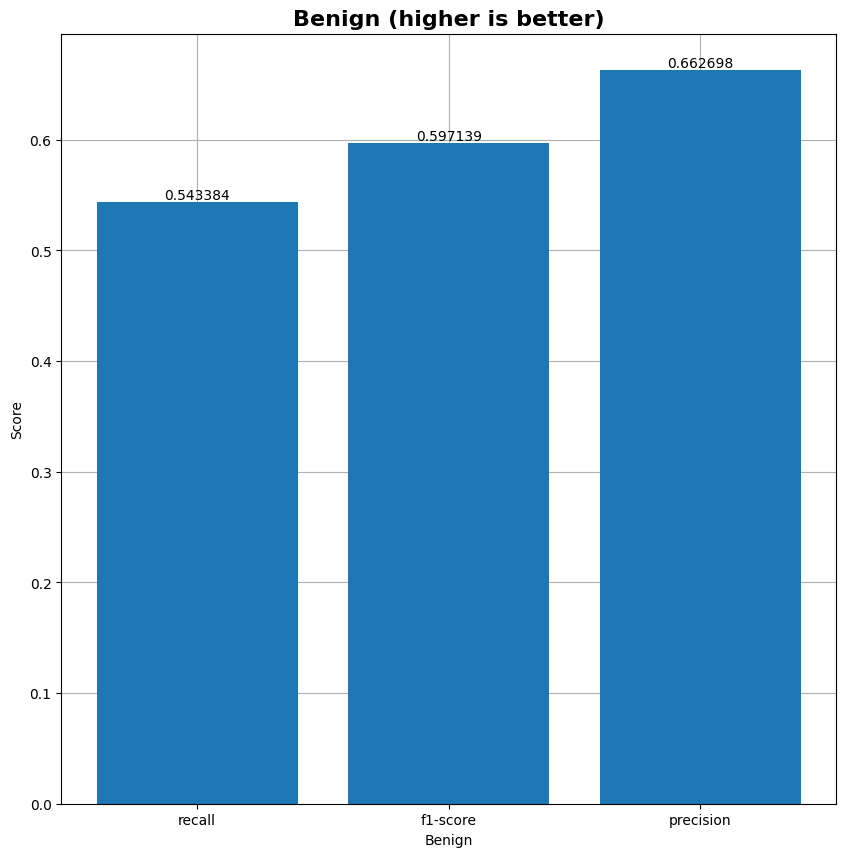

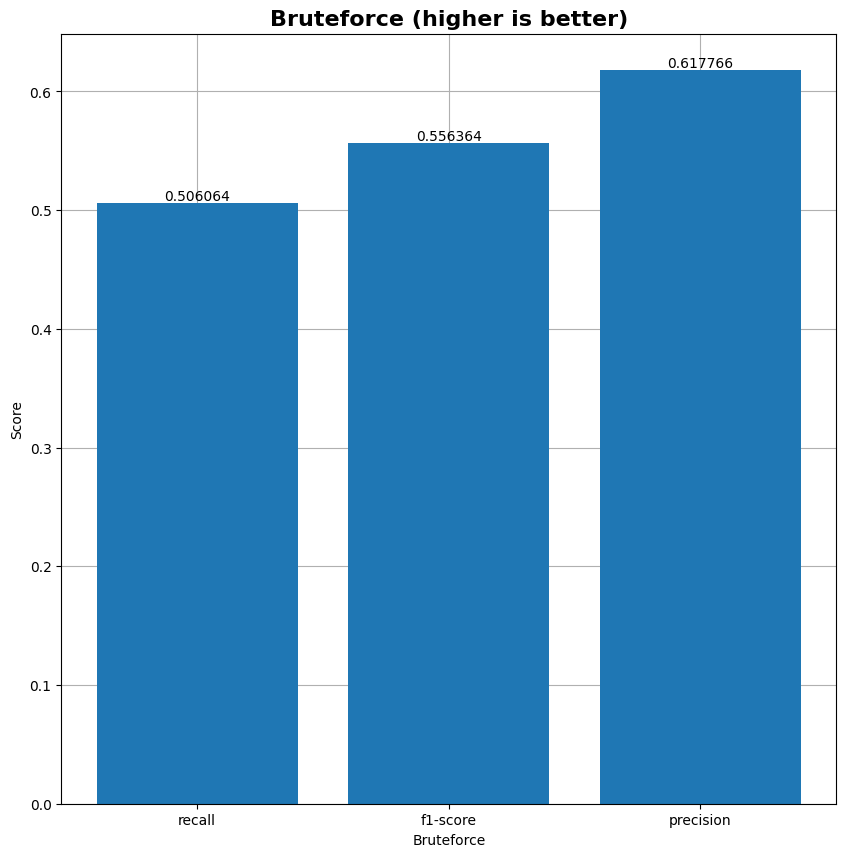

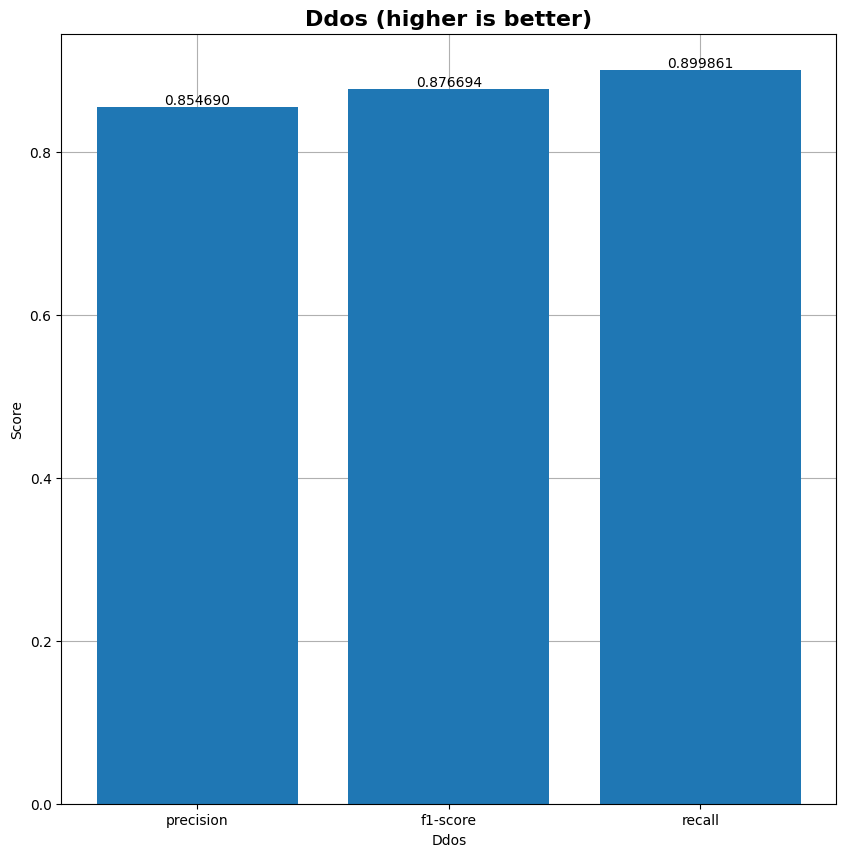

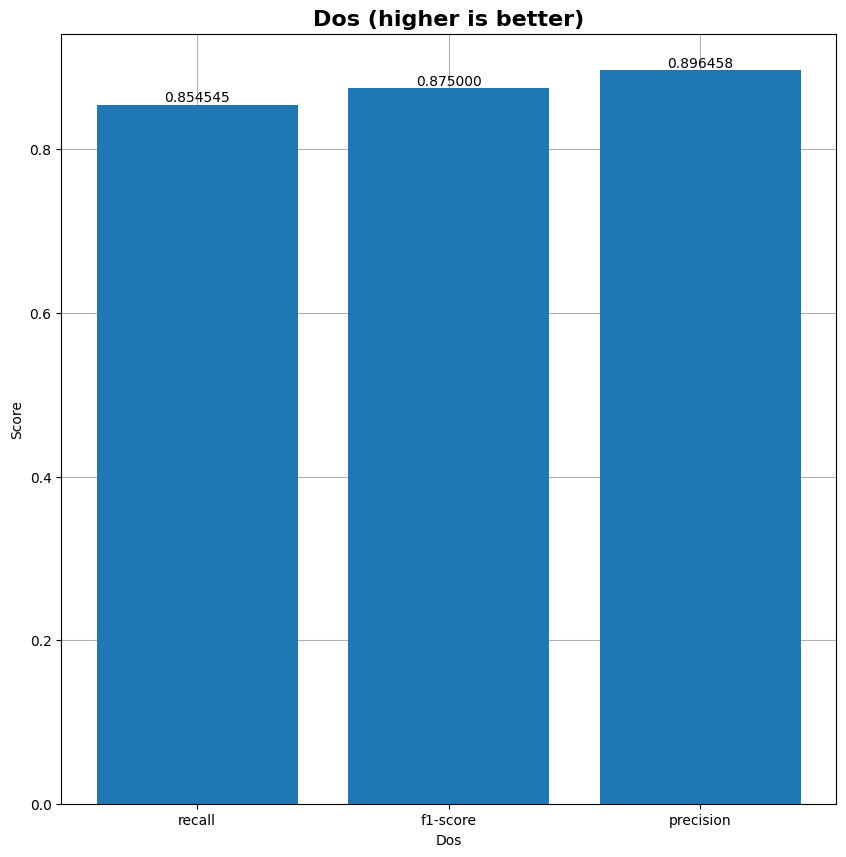

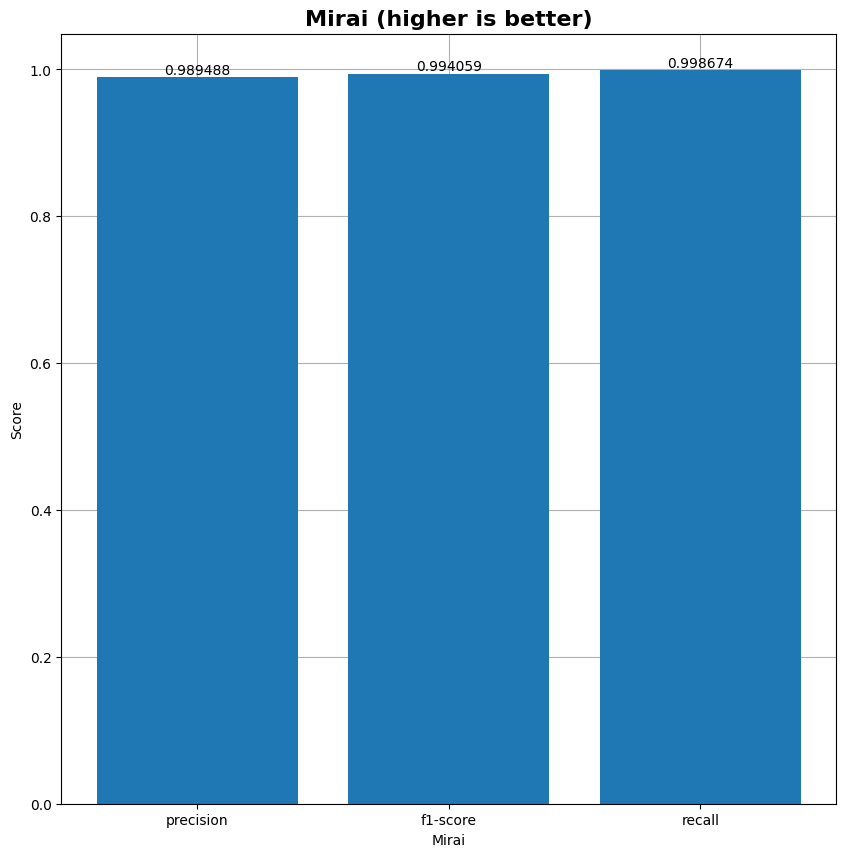

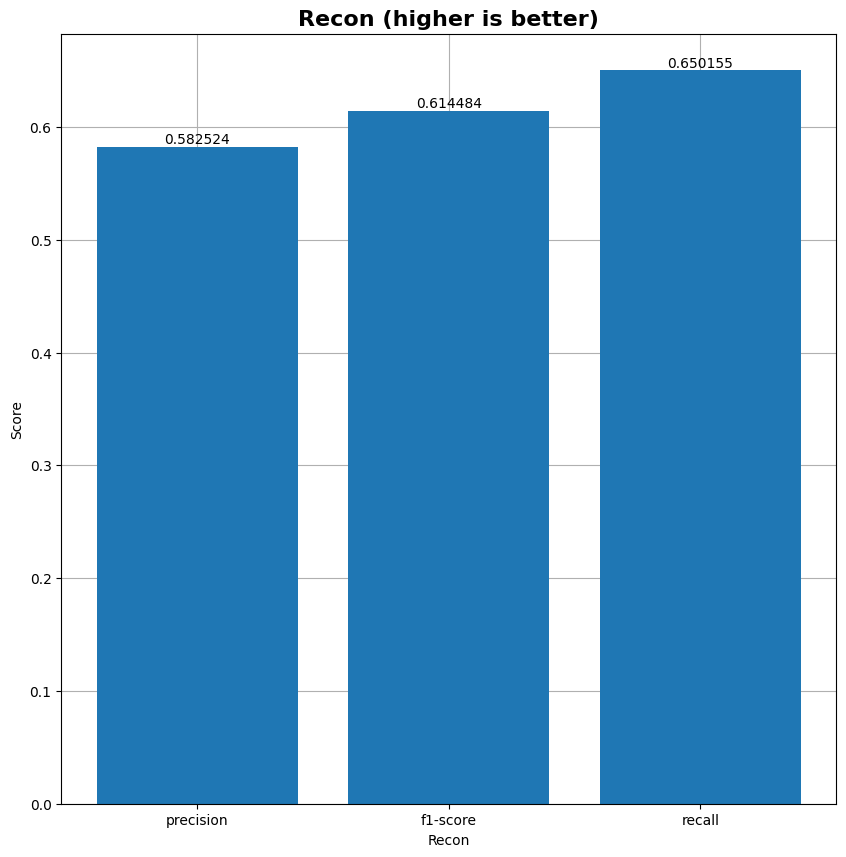

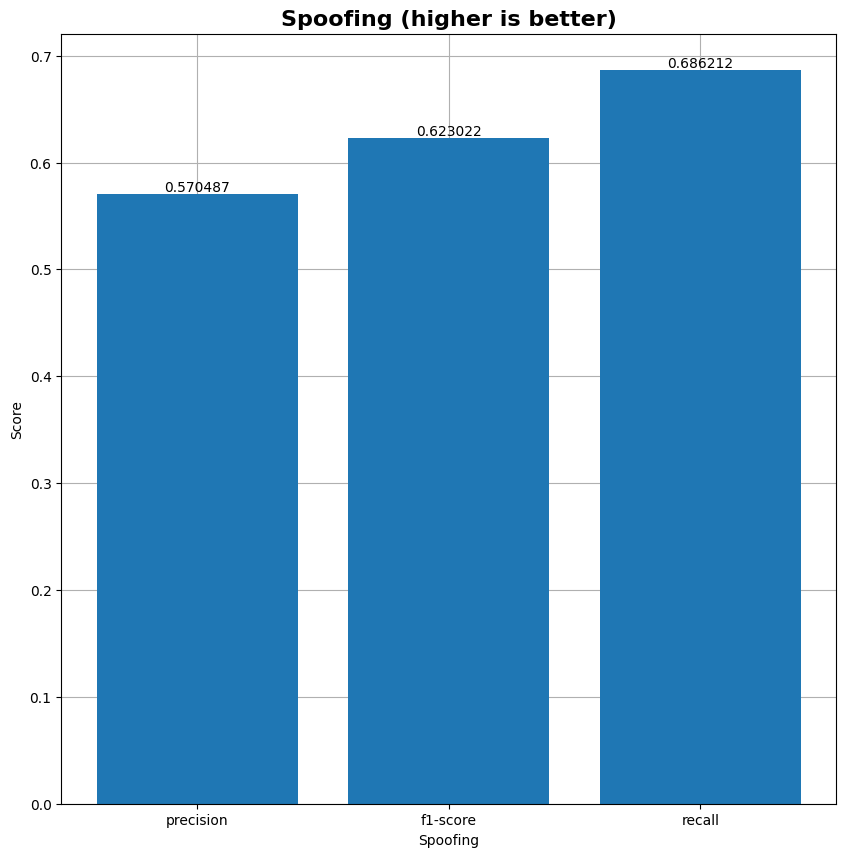

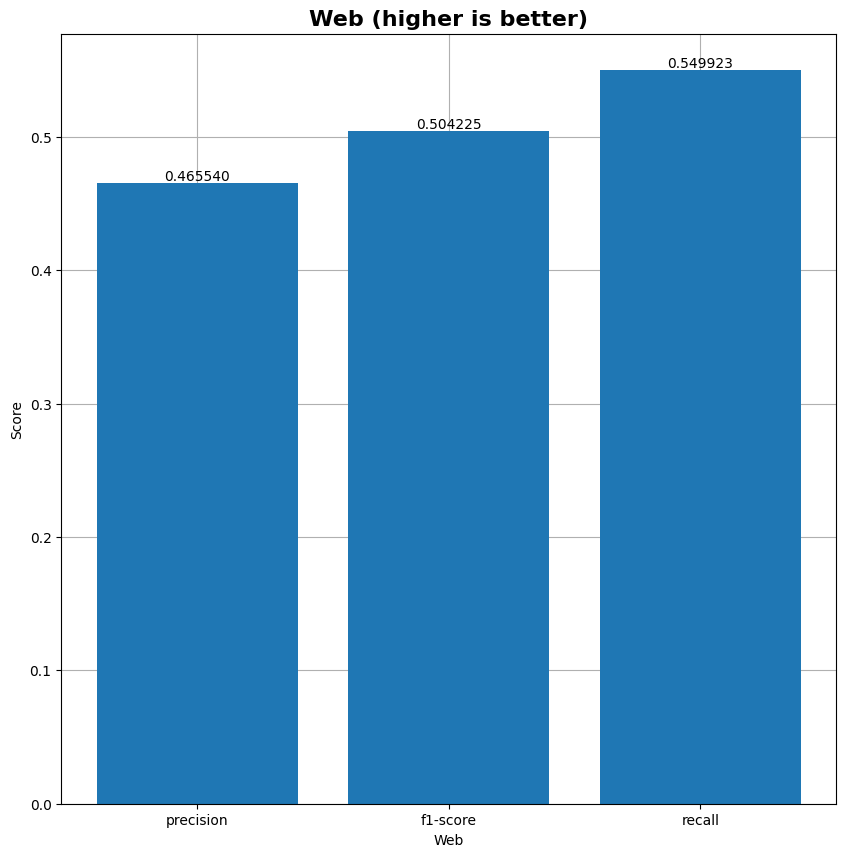

In [24]:
plot_mc(y_pred, y_test, "kNN")

In [25]:
model_name = "kNN_5000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Naive Bayes

In [26]:
%%time

start_time = time.perf_counter()

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

end_time = time.perf_counter()

NB_time = end_time - start_time

CPU times: user 40.8 ms, sys: 7 μs, total: 40.8 ms
Wall time: 39.7 ms


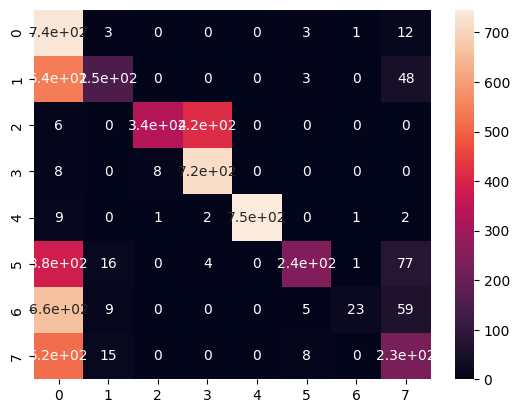

In [27]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [28]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(nb_clf, X_test)

In [29]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, NB_time]
results_dict["NB"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [30]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706


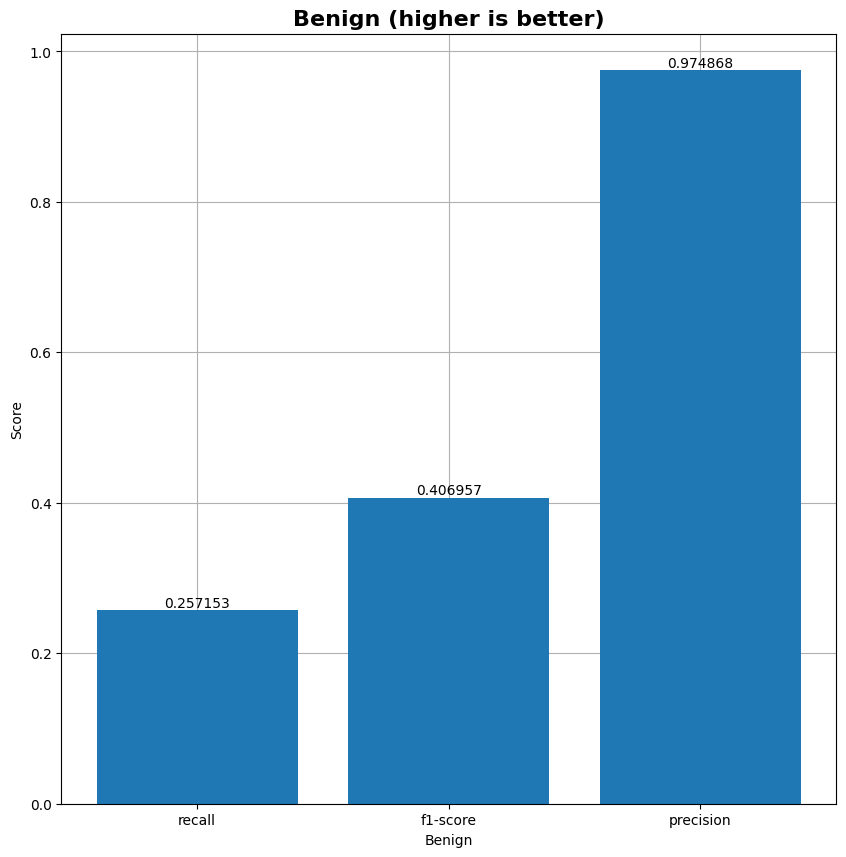

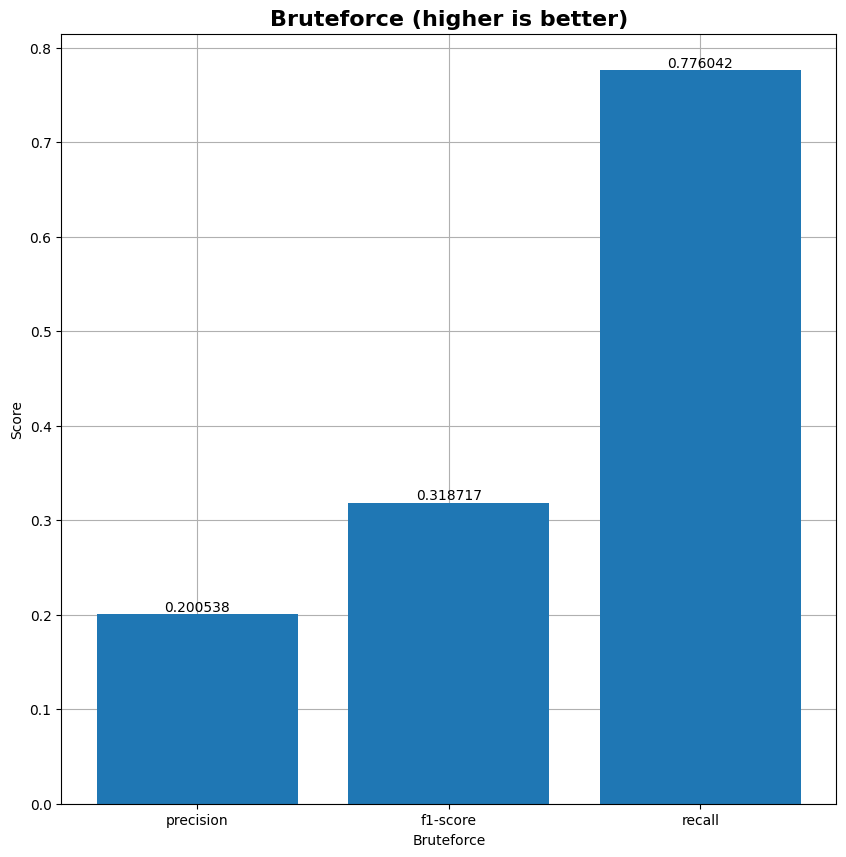

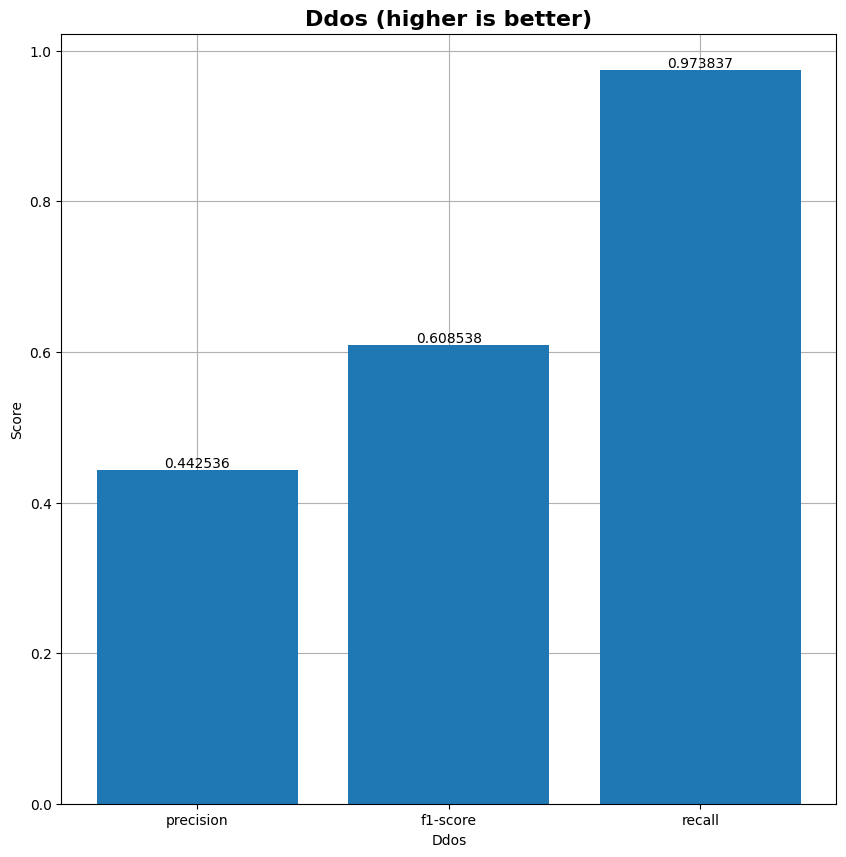

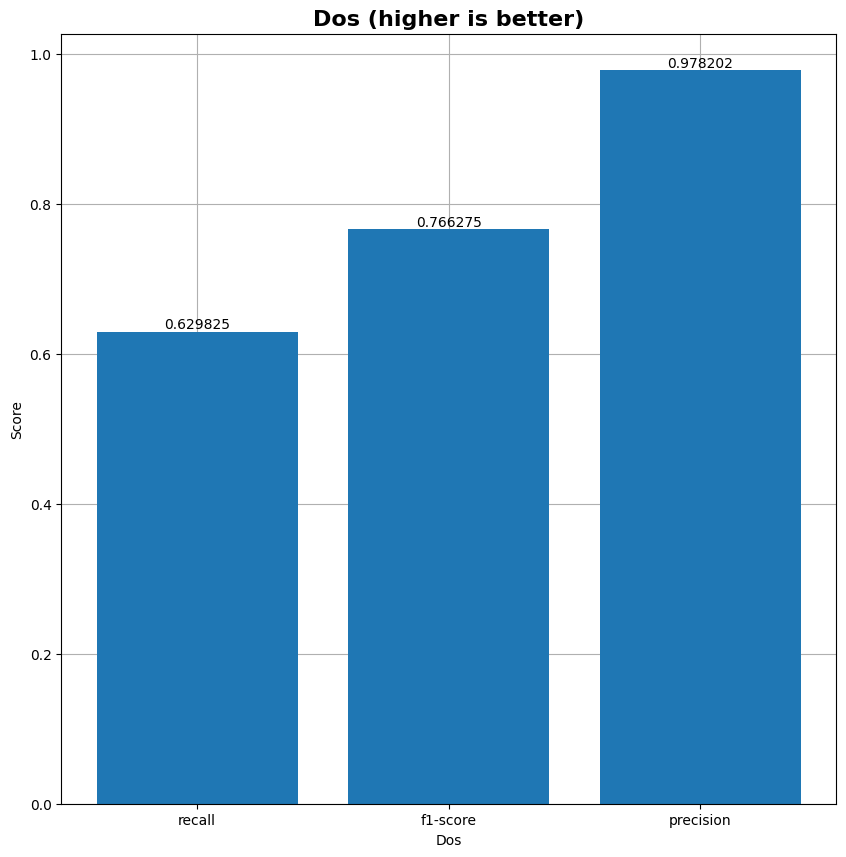

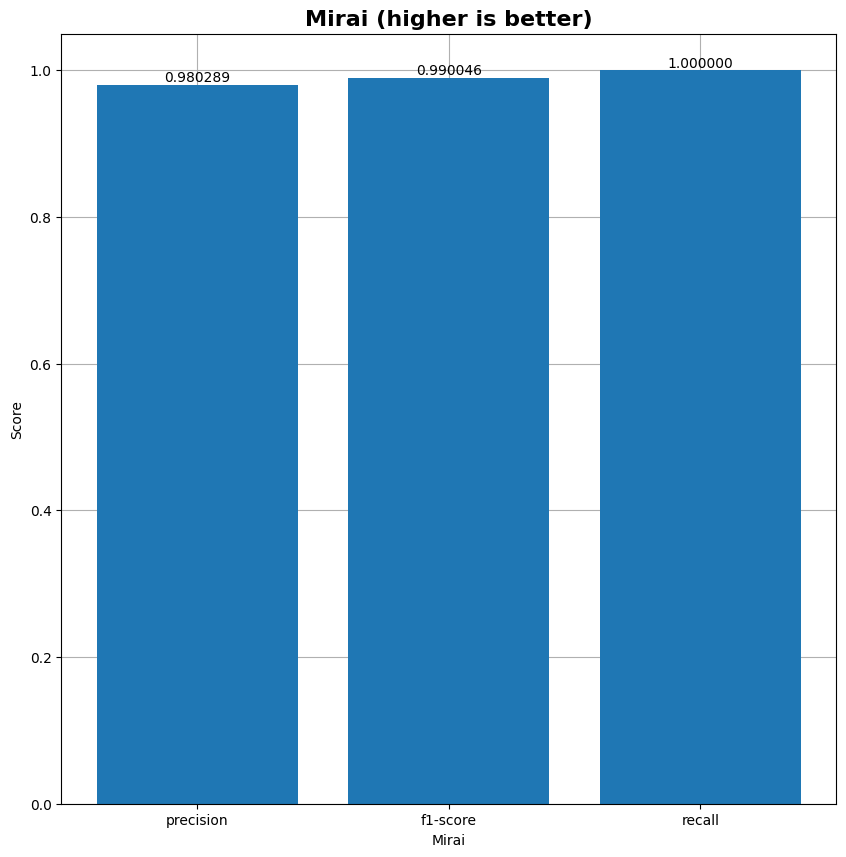

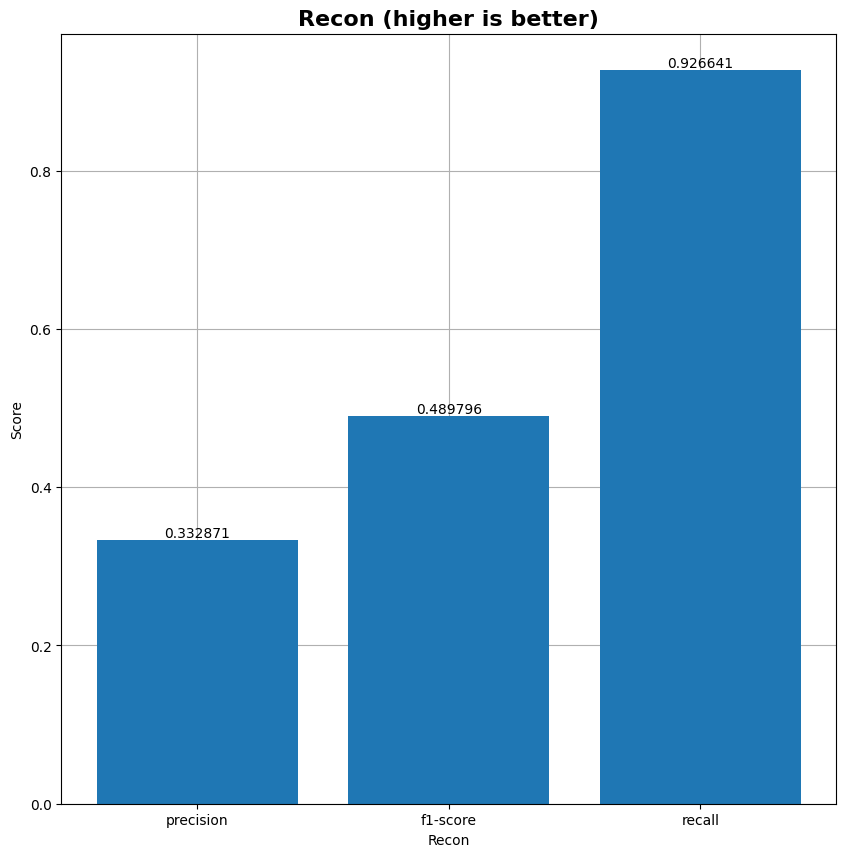

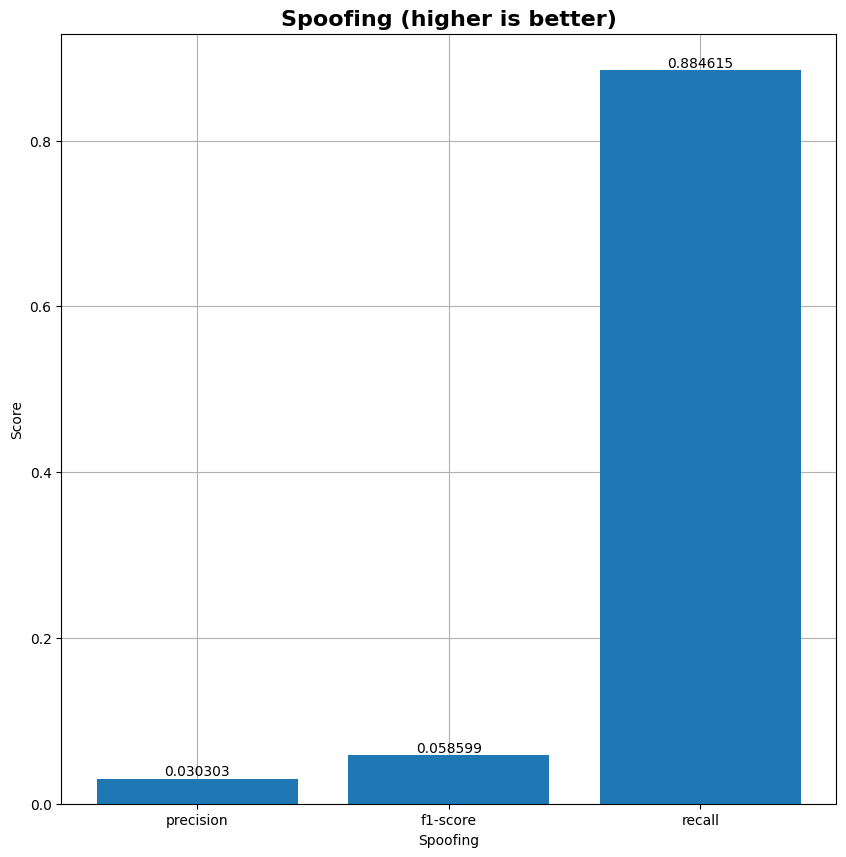

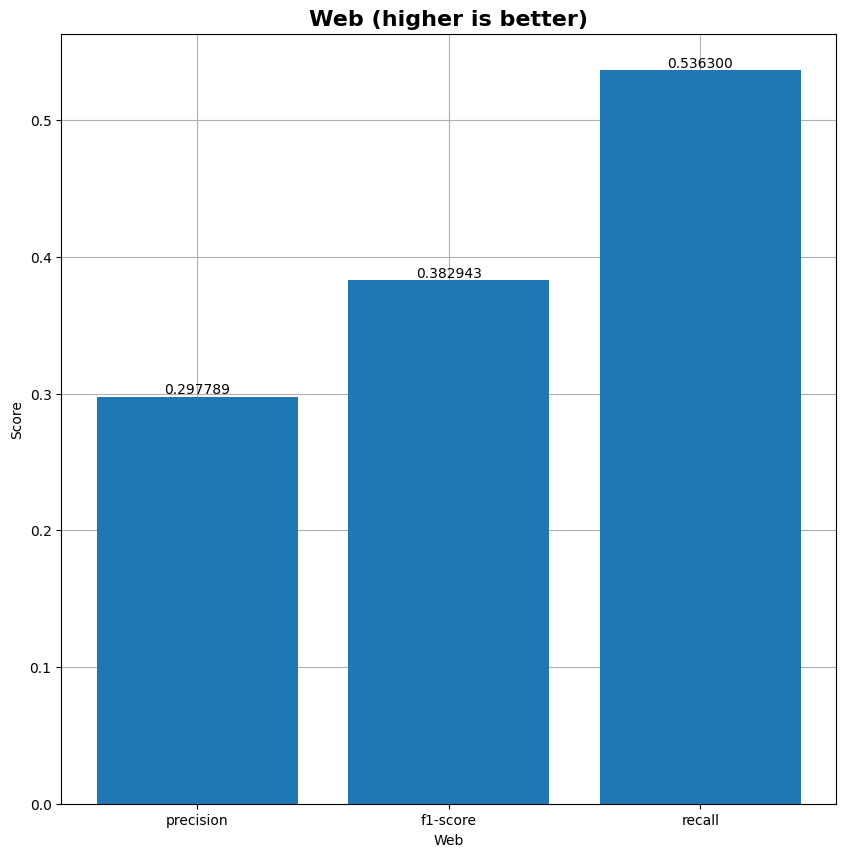

In [31]:
plot_mc(y_pred, y_test, "NB")

In [32]:
model_name = "NB_5000.sav"
pickle.dump(nb_clf, open(model_name, 'wb'))

# Logistic Regression

In [33]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

KeyboardInterrupt: 

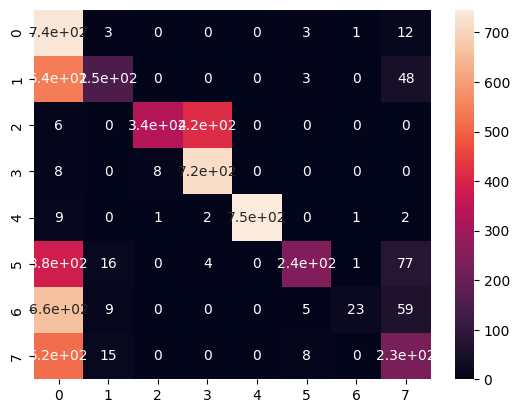

In [34]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [35]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [36]:
latency, cpu_usage = measure_latency_cpu_usage(lr_clf, X_test)

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LR_time]
results_dict["LR"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "LR")

In [ ]:
model_name = "LR_5000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [37]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 13.4 s, sys: 127 ms, total: 13.5 s
Wall time: 2.05 s


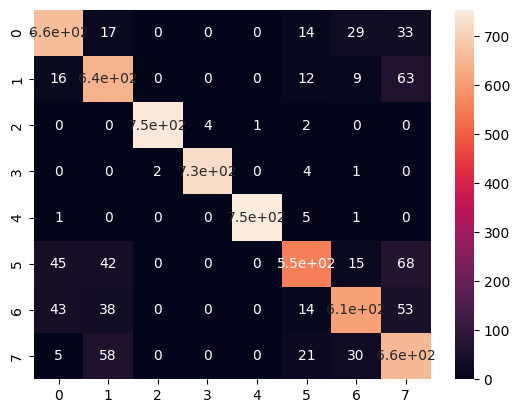

In [38]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [39]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [40]:
latency, cpu_usage = measure_latency_cpu_usage(rf_clf, X_test)

In [41]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, RF_time]
results_dict["RF"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [42]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707


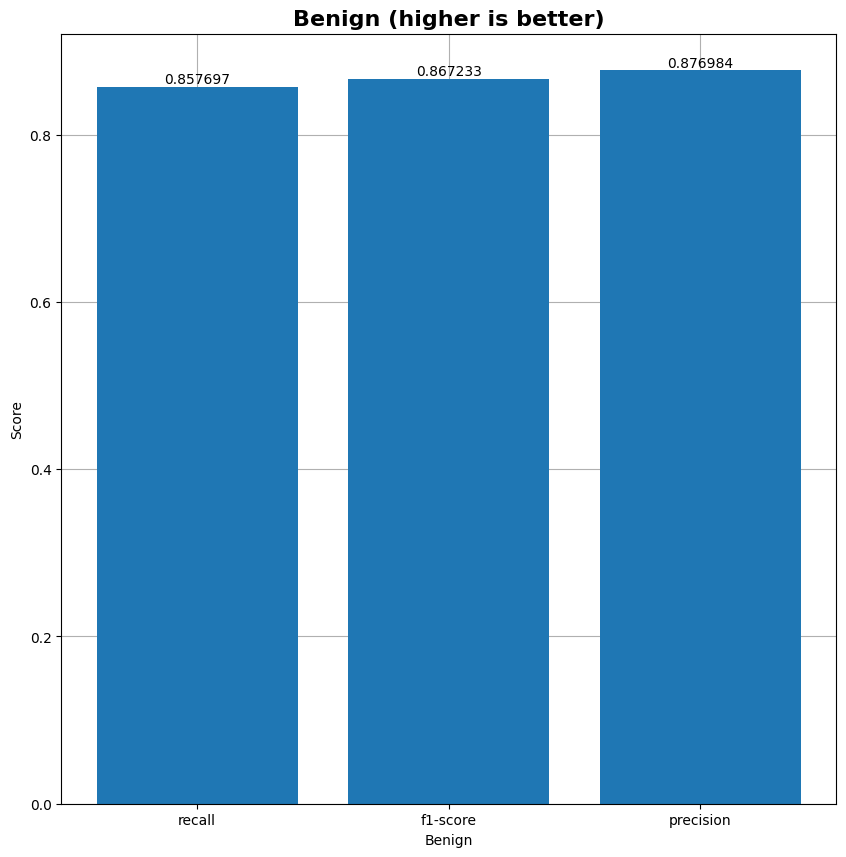

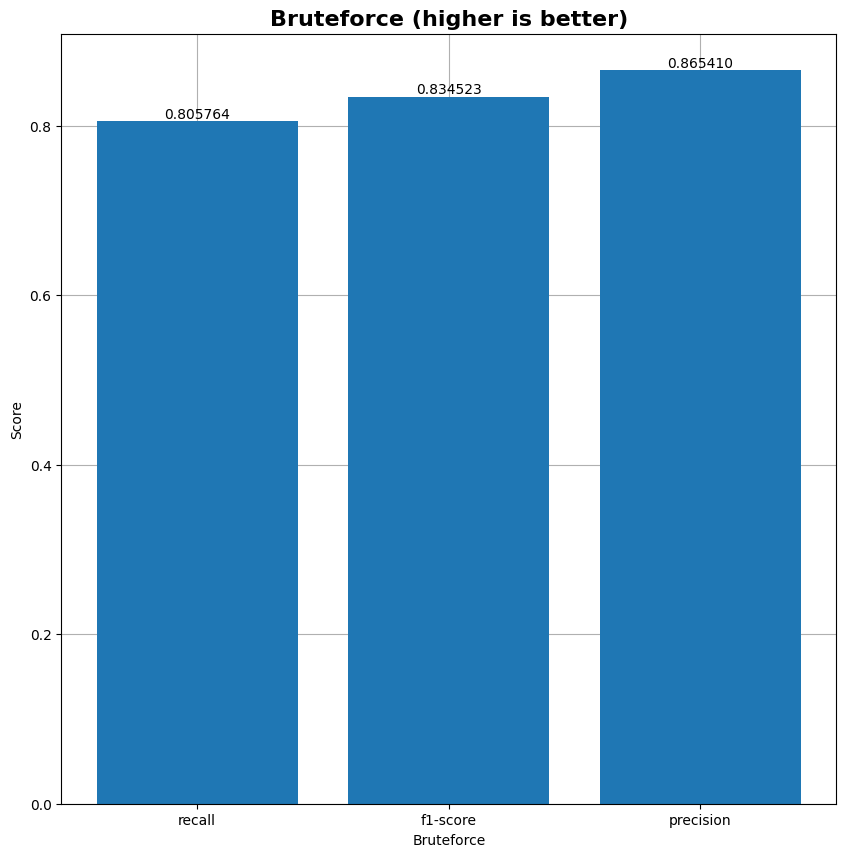

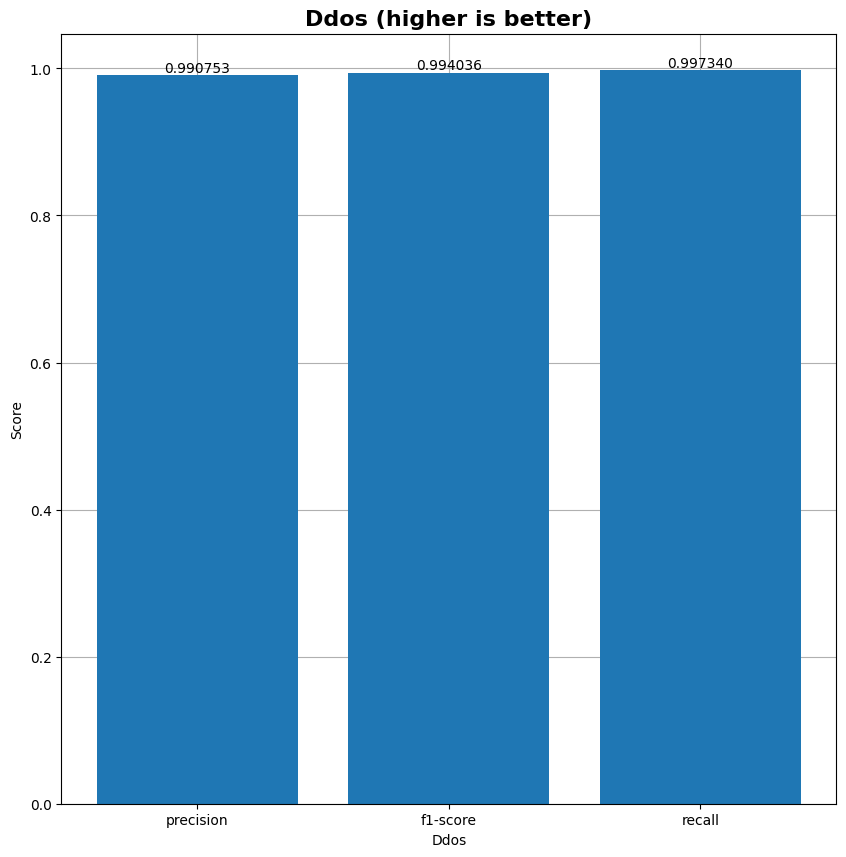

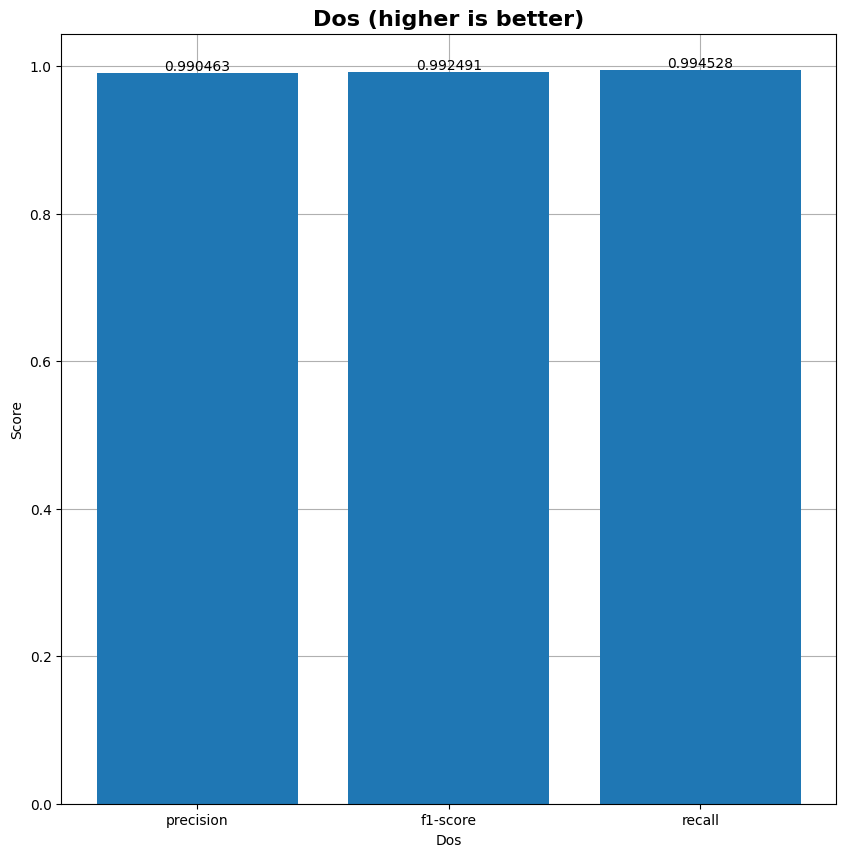

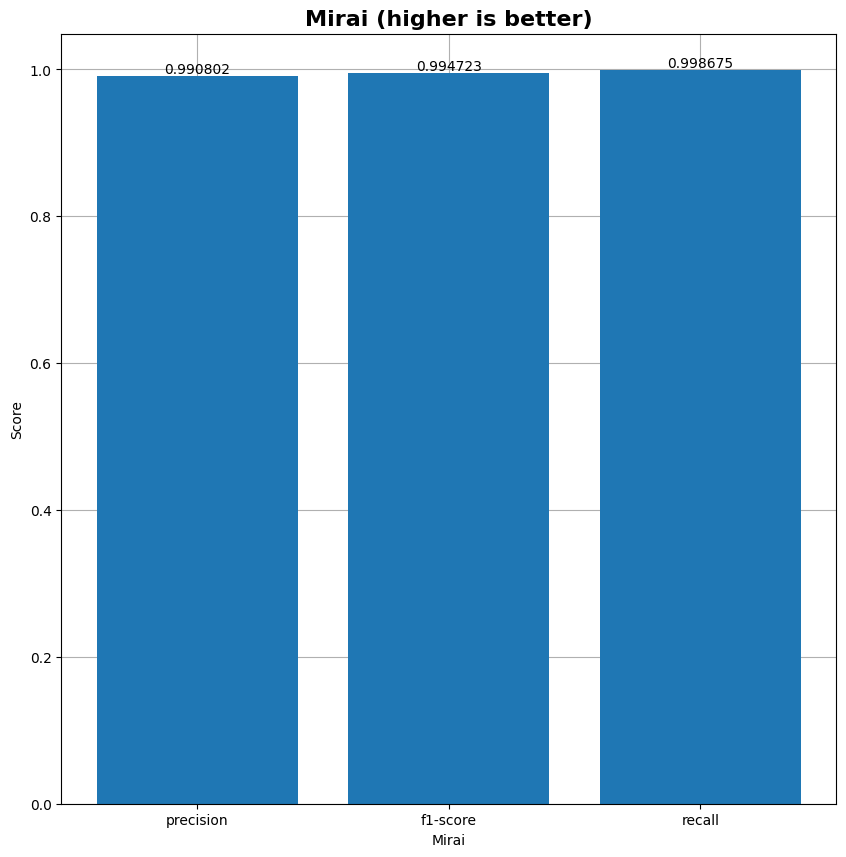

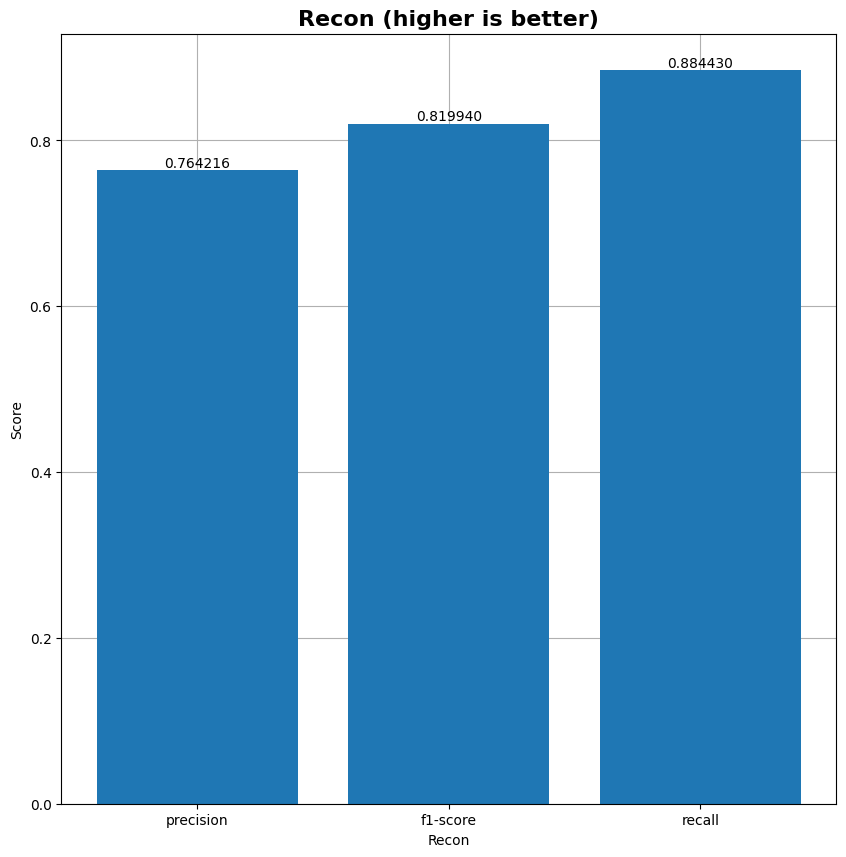

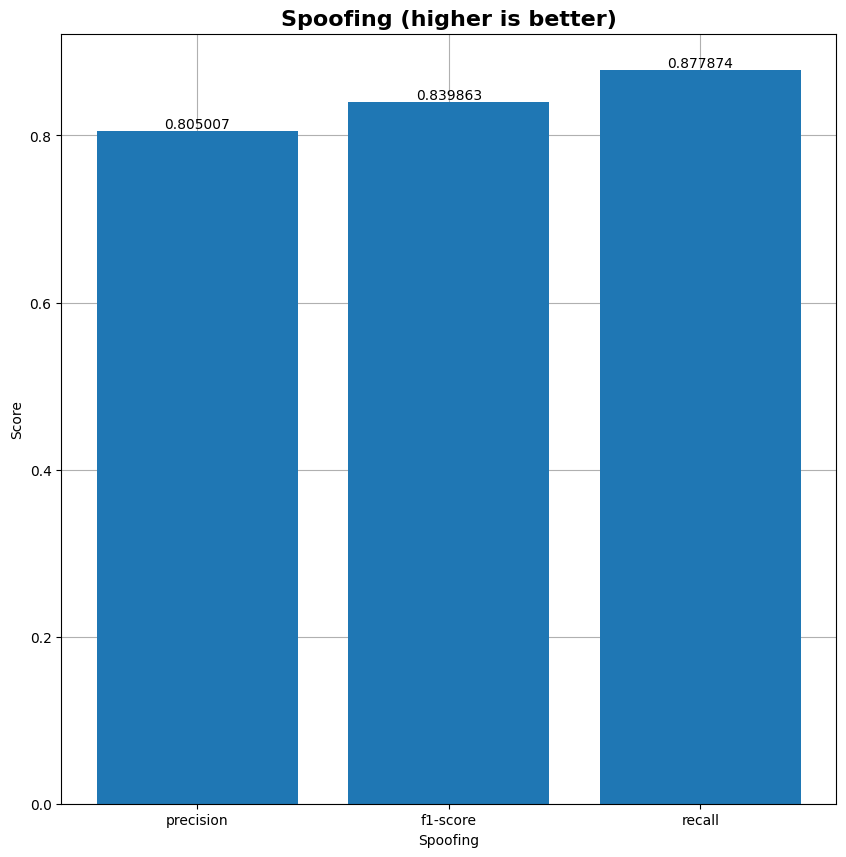

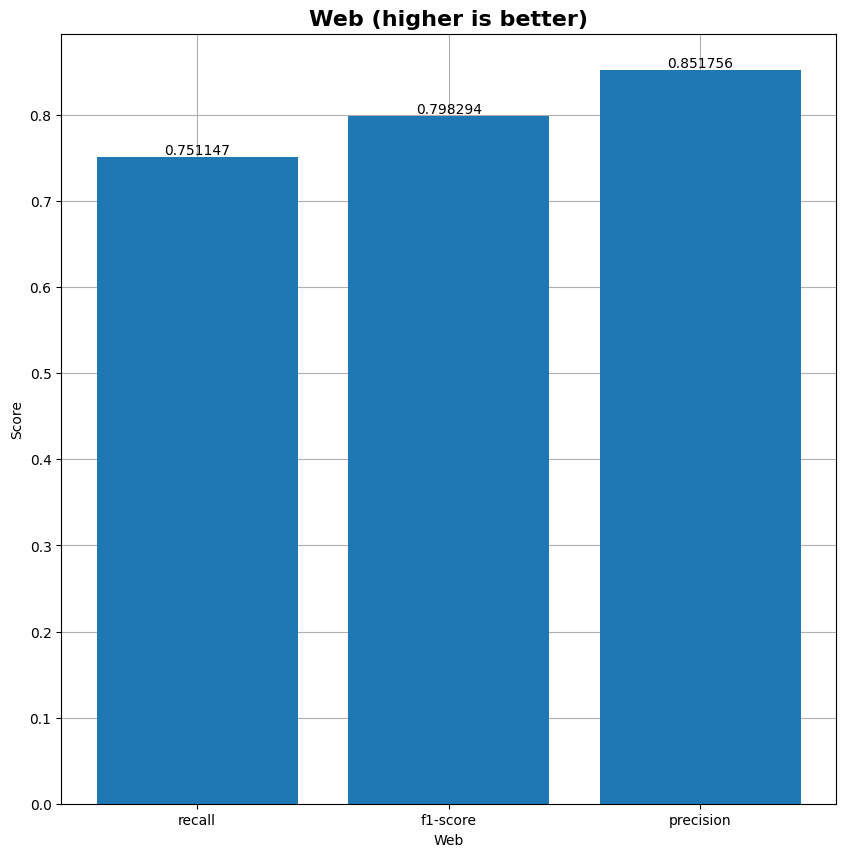

In [43]:
plot_mc(y_pred, y_test, "RF")

In [44]:
model_name = "RF_5000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [45]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 26.2 s, sys: 170 ms, total: 26.4 s
Wall time: 3.9 s


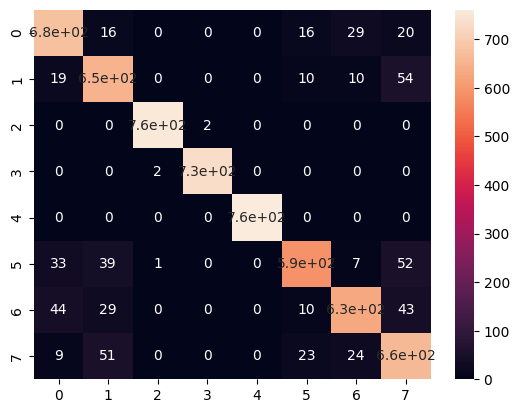

In [46]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [47]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [48]:
latency, cpu_usage = measure_latency_cpu_usage(xgb_clf, X_test)

In [49]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, XGB_time]
results_dict["XGBoost"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [50]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707
XGBoost,0.909500,0.911307,0.909682,0.909500,0.896765,0.363833,1.874167,1.369002,0.029147,3.904210


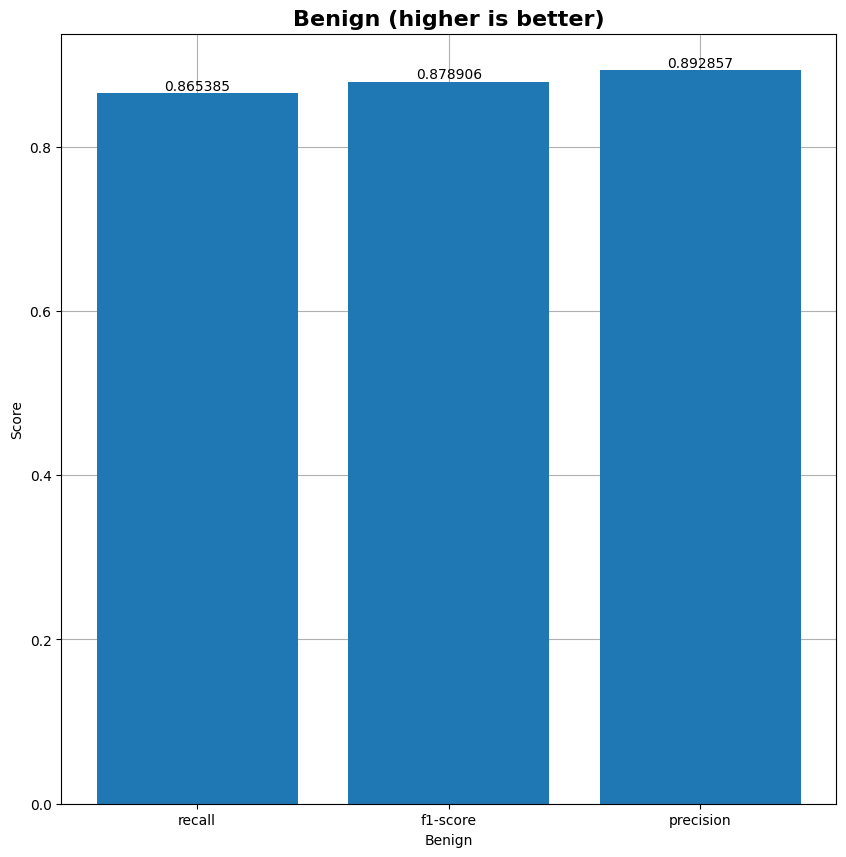

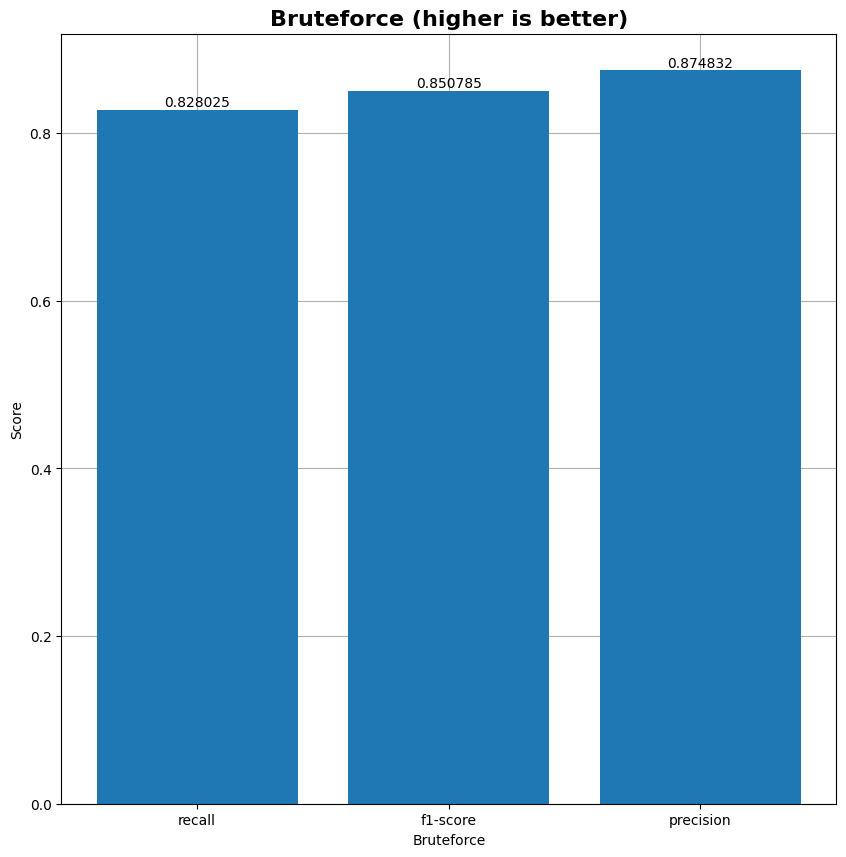

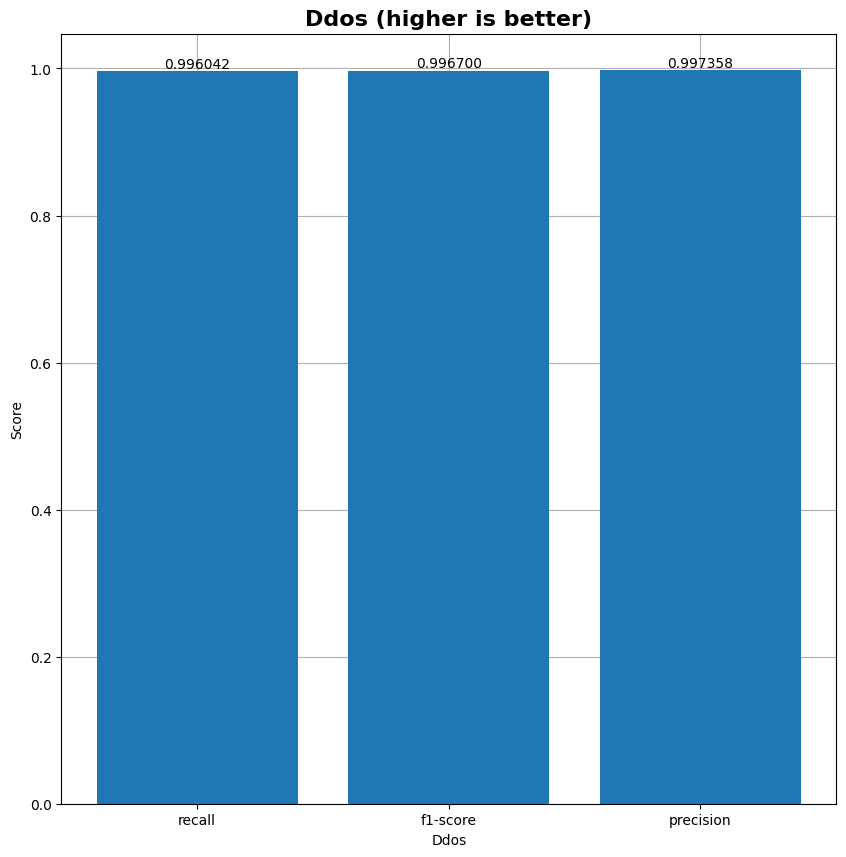

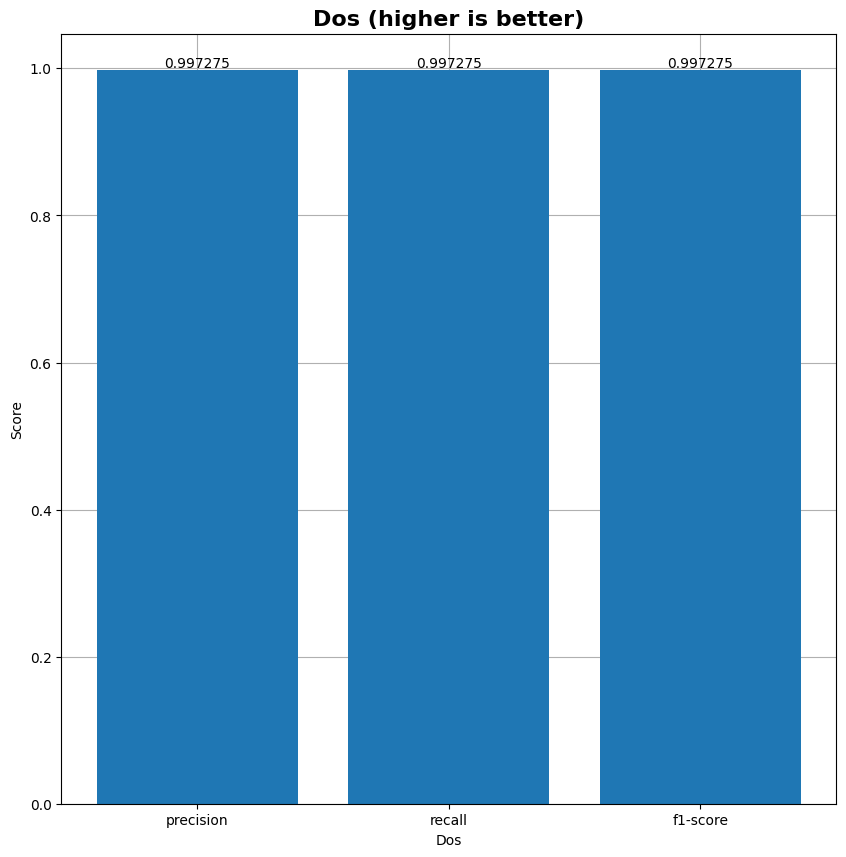

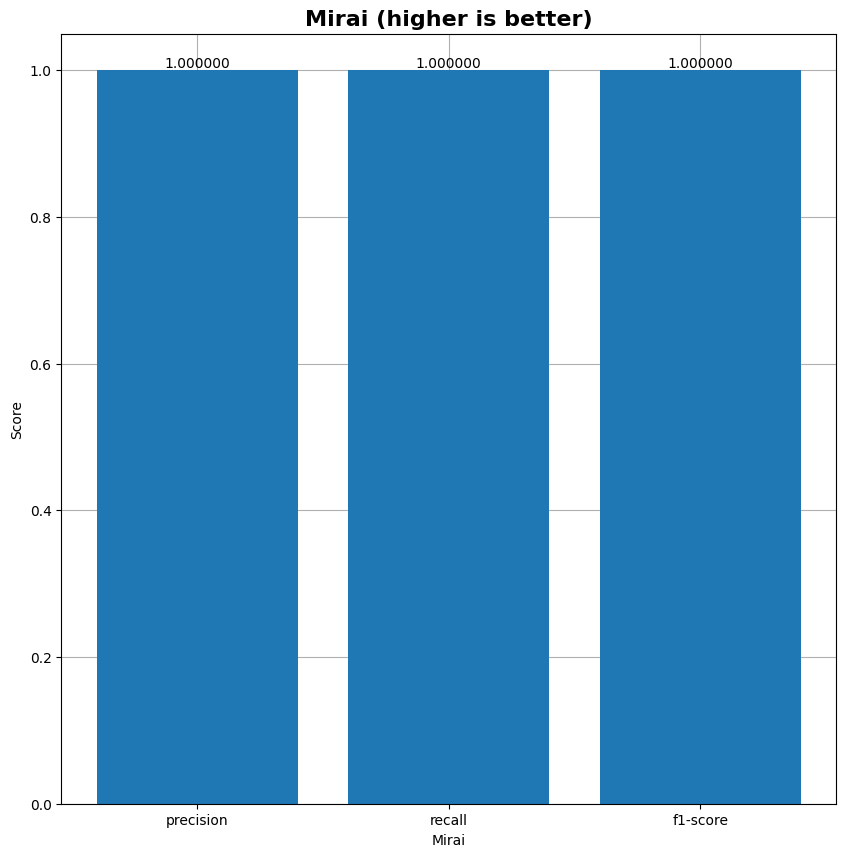

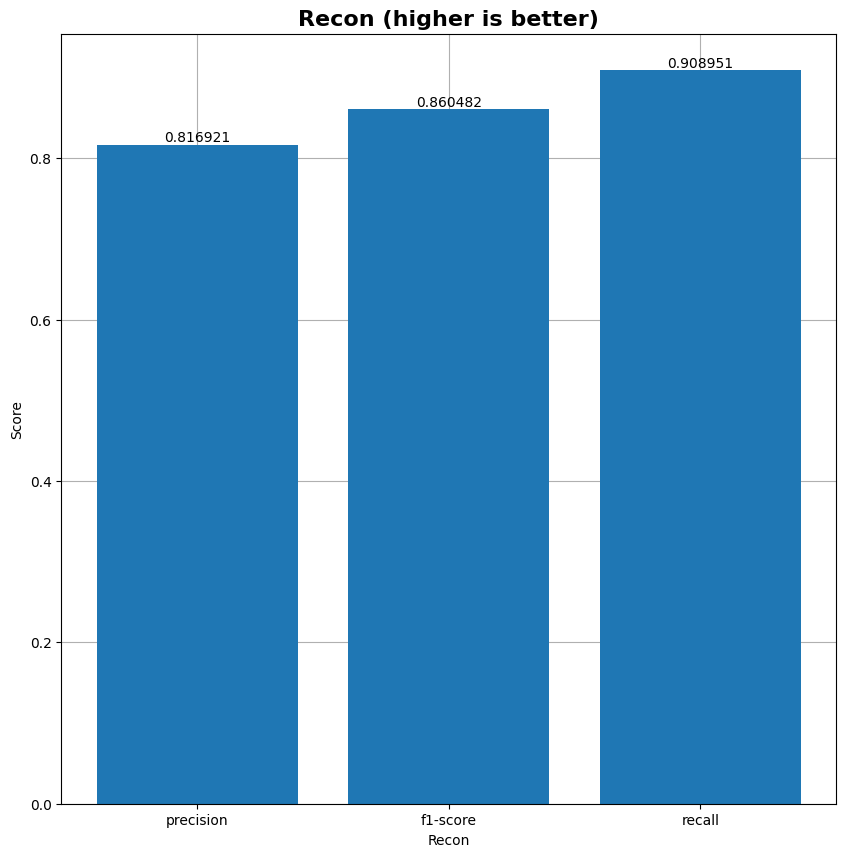

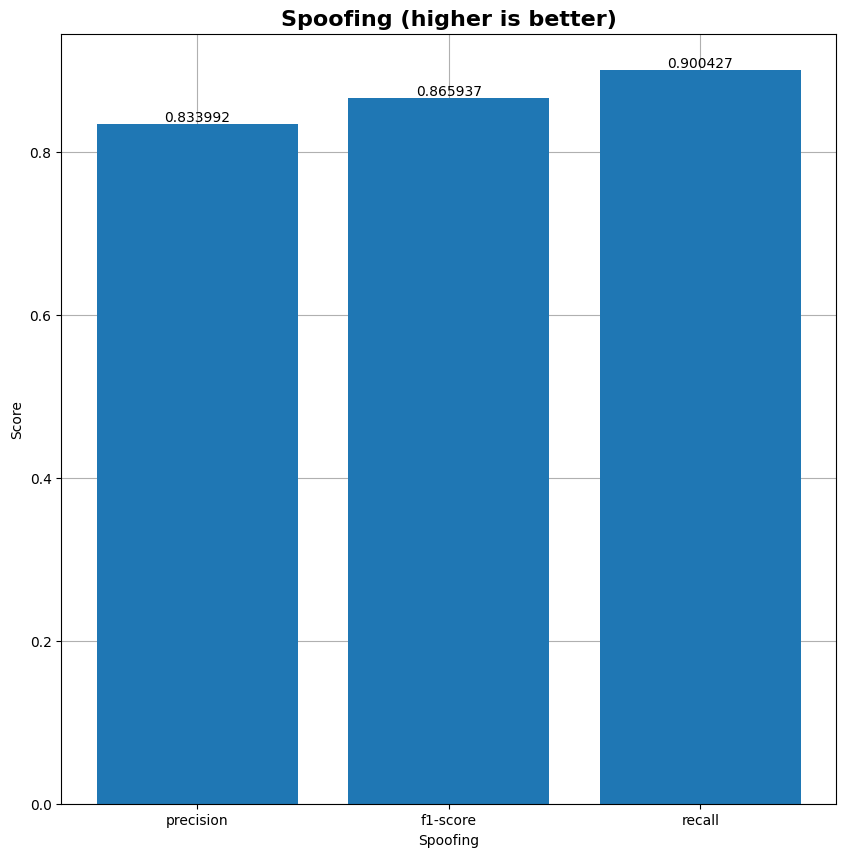

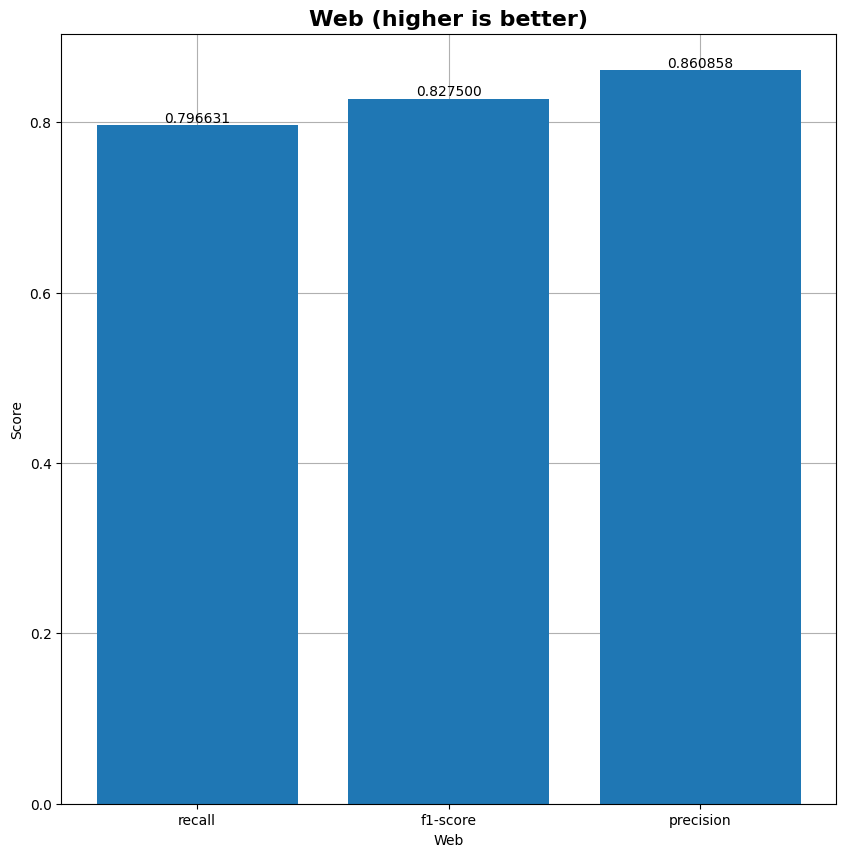

In [51]:
plot_mc(y_pred, y_test, "XGBoost")

In [52]:
model_name = "XGB_5000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [53]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5114
[LightGBM] [Info] Number of data points in the train set: 34000, number of used features: 39
[LightGBM] [Info] Start training from score -2.080854
[LightGBM] [Info] Start training from score -2.077796
[LightGBM] [Info] Start training from score -2.081090
[LightGBM] [Info] Start training from score -2.075684
[LightGBM] [Info] Start training from score -2.082033
[LightGBM] [Info] Start training from score -2.072641
[LightGBM] [Info] Start training from score -2.081561
[LightGBM] [Info] Start training from score -2.083922
CPU times: user 8.27 s, sys: 104 ms, total: 8.37 s
Wall time: 2.13 s


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


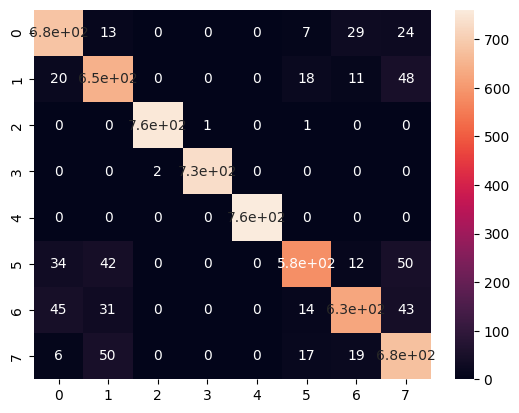

In [54]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [55]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [56]:
latency, cpu_usage = measure_latency_cpu_usage(lgbm_clf, X_test)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [57]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LightGBM_Time]
results_dict["LightGBM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [58]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707
XGBoost,0.909500,0.911307,0.909682,0.909500,0.896765,0.363833,1.874167,1.369002,0.029147,3.904210
LightGBM,0.910500,0.912470,0.910583,0.910500,0.897959,0.359667,1.849667,1.360025,0.077371,2.129981


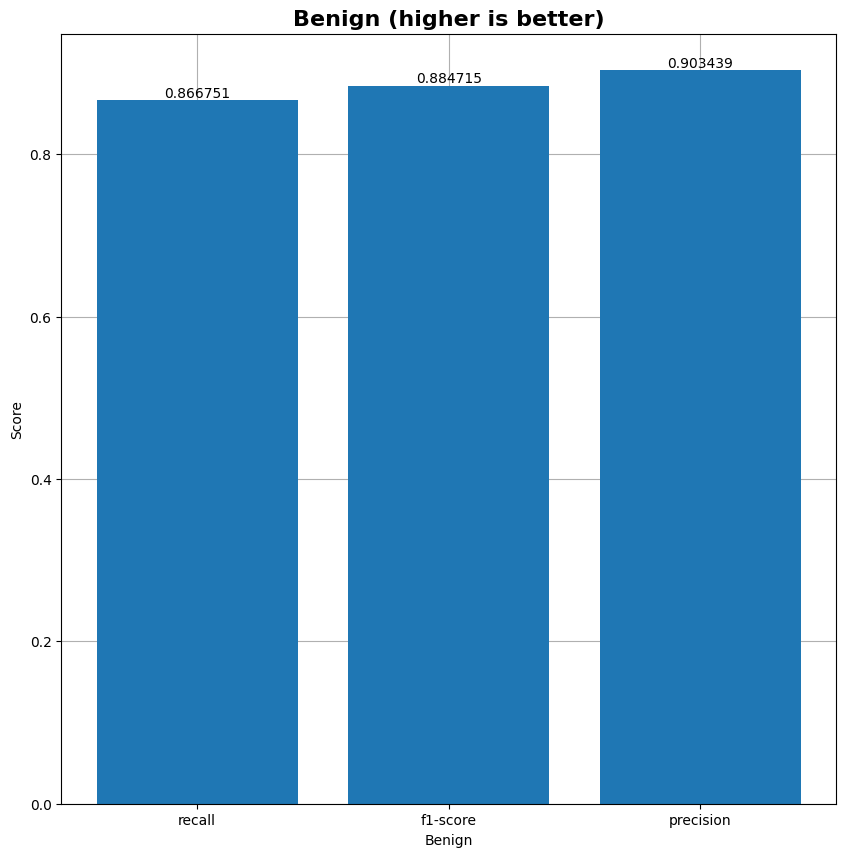

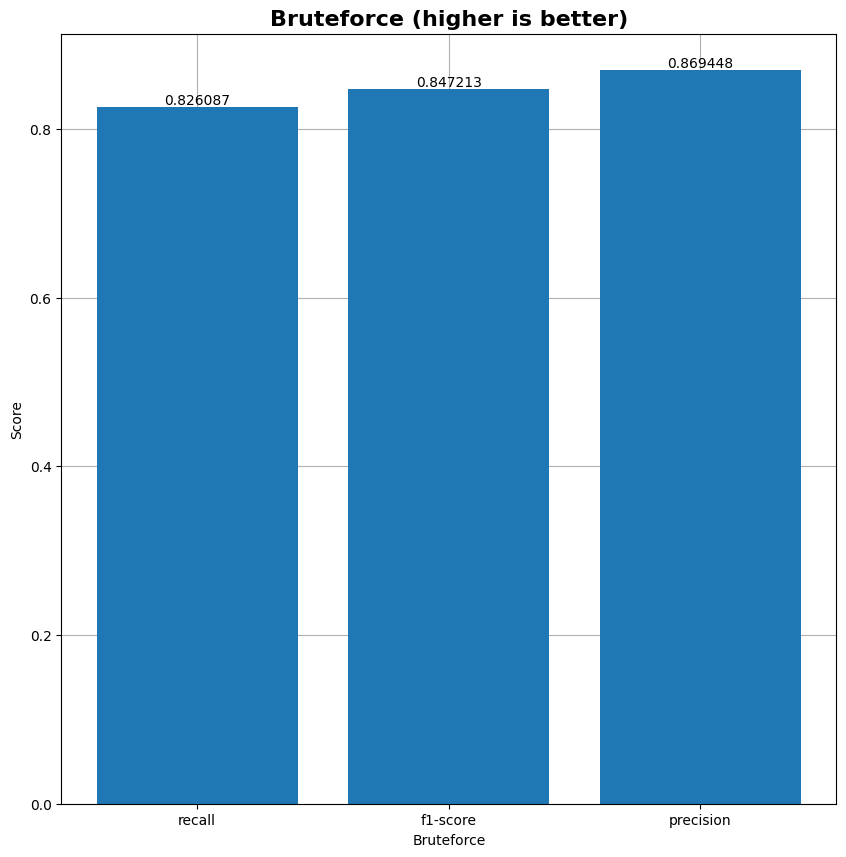

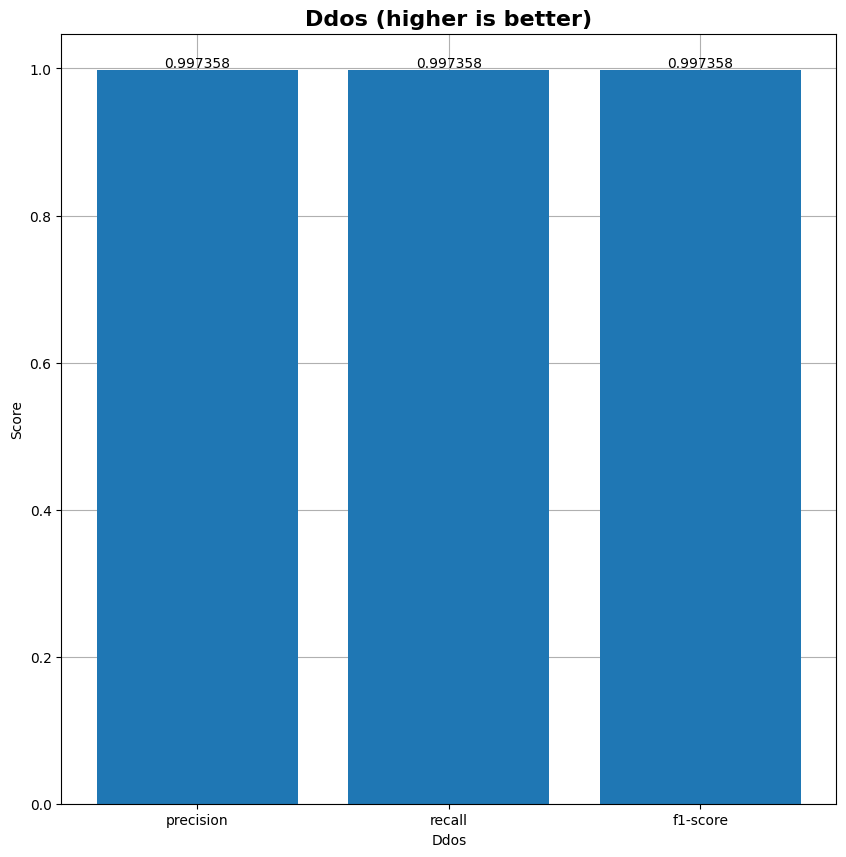

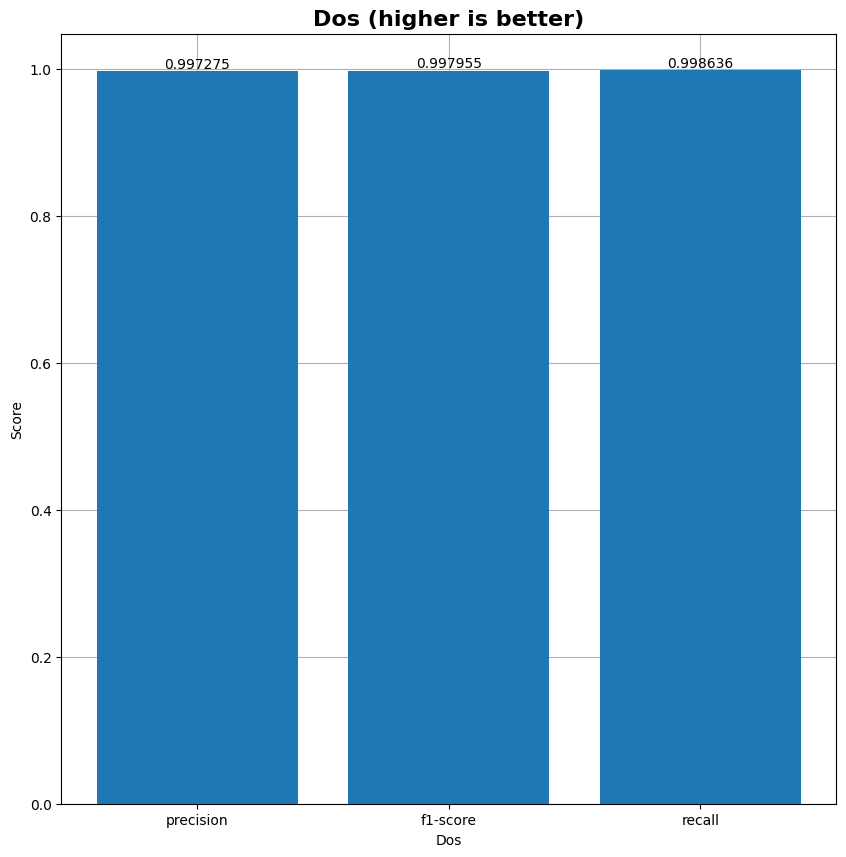

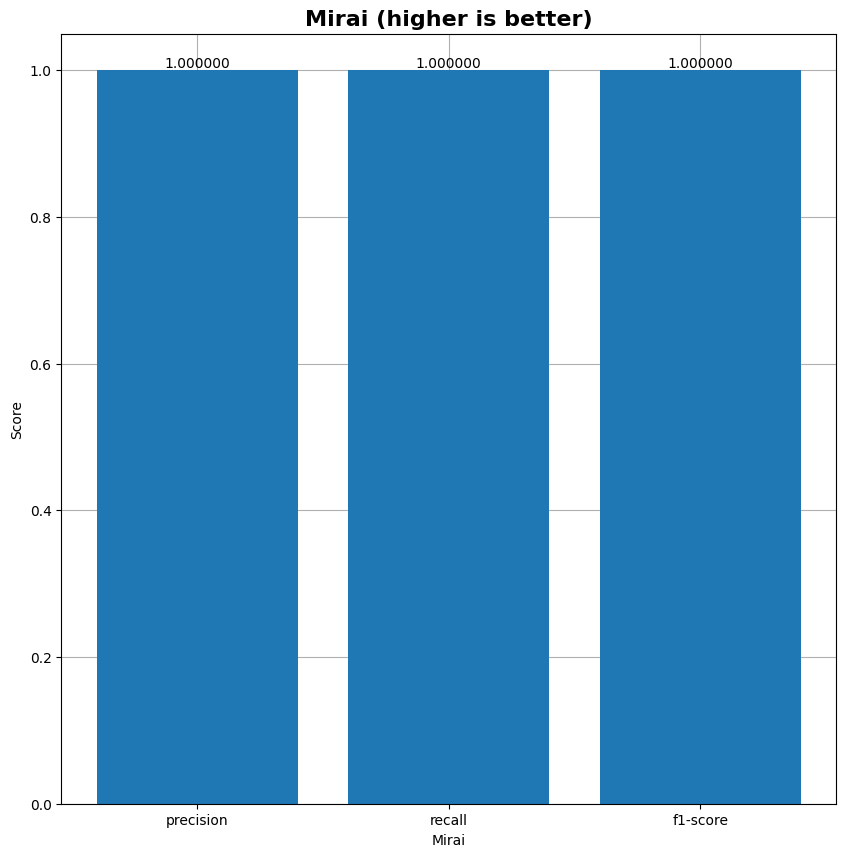

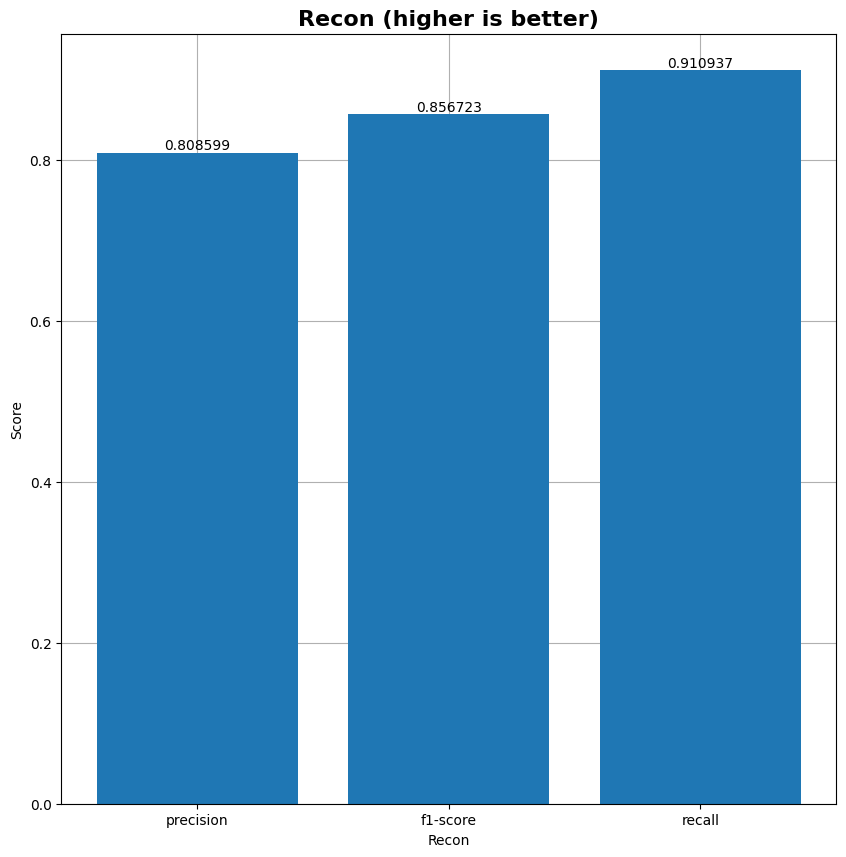

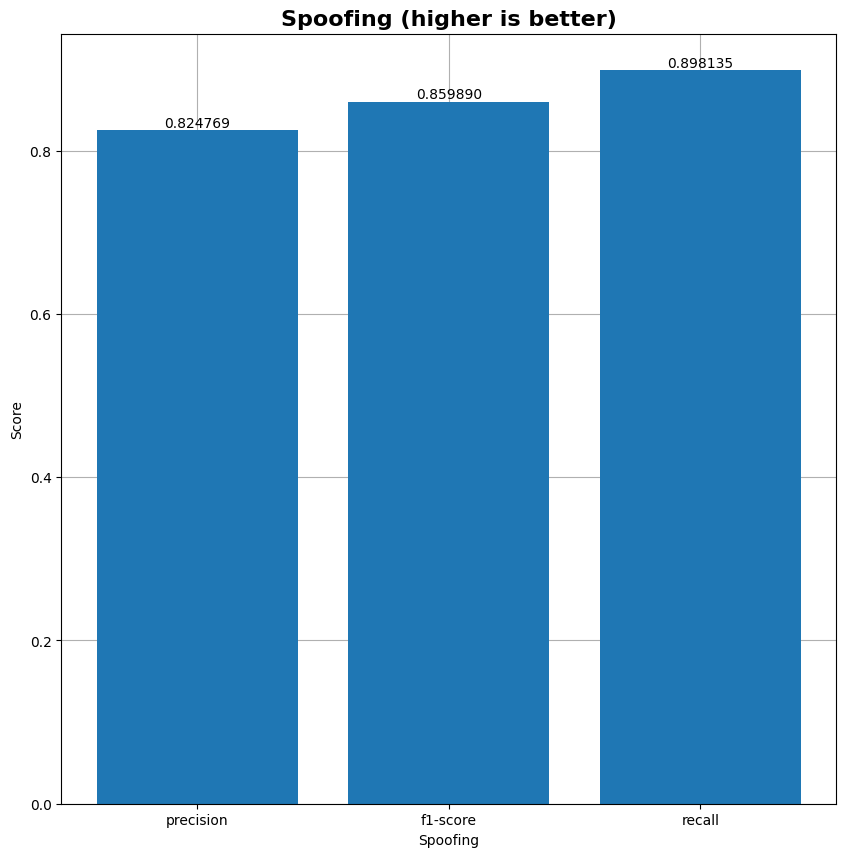

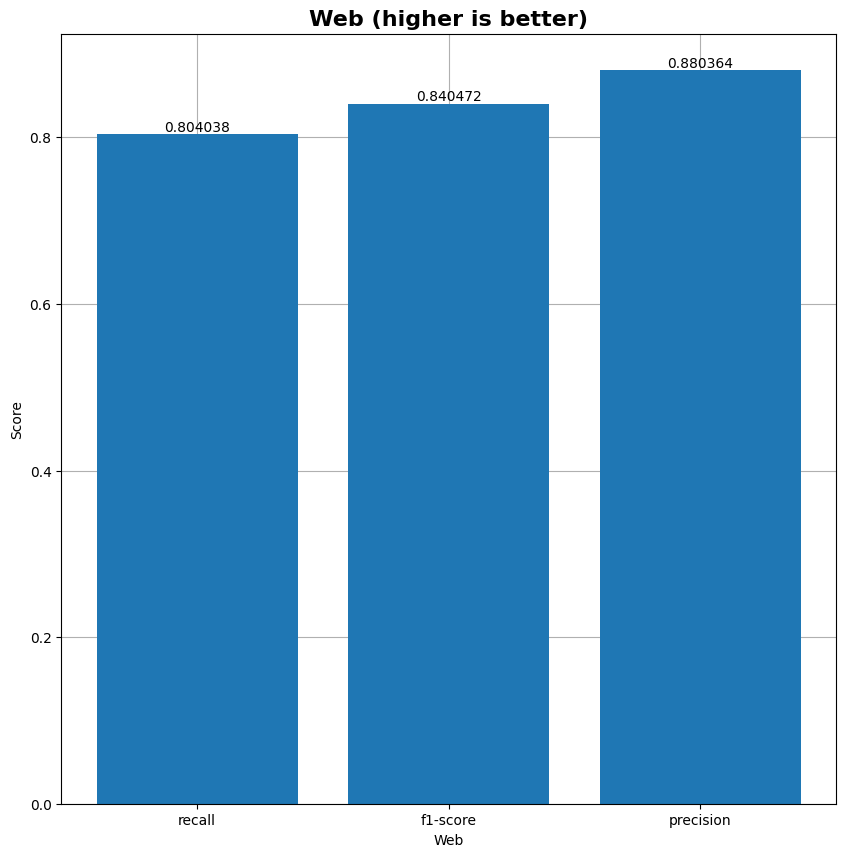

In [59]:
plot_mc(y_pred, y_test, "LightGBM")

In [60]:
model_name = "LightGBM_5000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# CatBoost

In [61]:
%%time

start_time = time.perf_counter()

cb_clf = CatBoostClassifier(silent = True)
cb_clf.fit(X_train, y_train)

y_pred = cb_clf.predict(X_test)

end_time = time.perf_counter()

CatBoost_Time = end_time - start_time

CPU times: user 2min 37s, sys: 19.1 s, total: 2min 57s
Wall time: 25.5 s


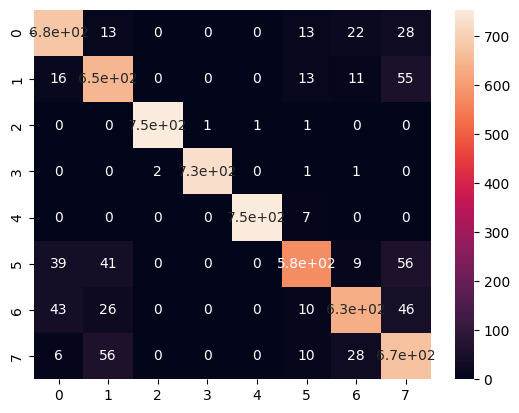

In [62]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [63]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [64]:
latency, cpu_usage = measure_latency_cpu_usage(cb_clf, X_test)

In [65]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, CatBoost_Time]
results_dict["CatBoost"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [66]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707
XGBoost,0.909500,0.911307,0.909682,0.909500,0.896765,0.363833,1.874167,1.369002,0.029147,3.904210
LightGBM,0.910500,0.912470,0.910583,0.910500,0.897959,0.359667,1.849667,1.360025,0.077371,2.129981
CatBoost,0.907500,0.910157,0.907818,0.907500,0.894562,0.371500,1.918833,1.385220,0.089468,25.470413


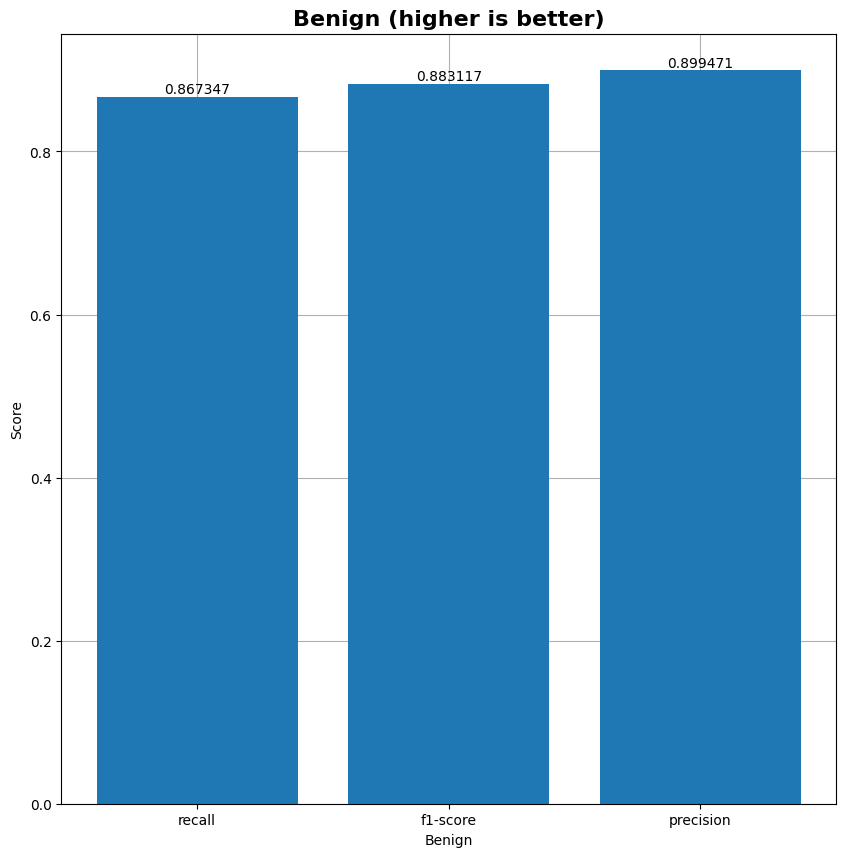

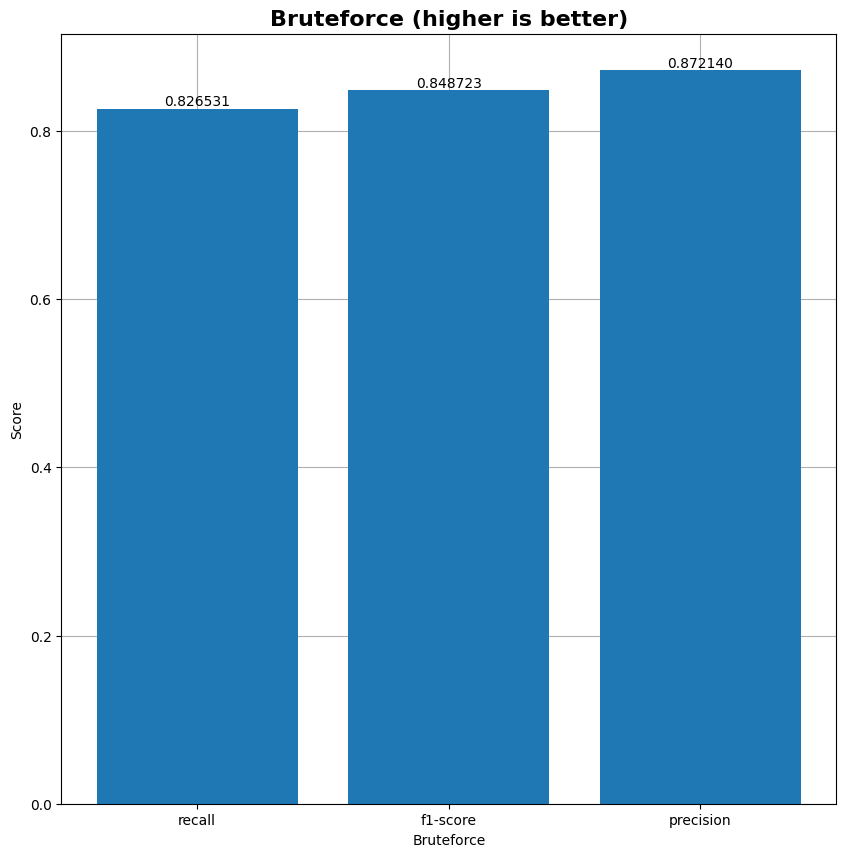

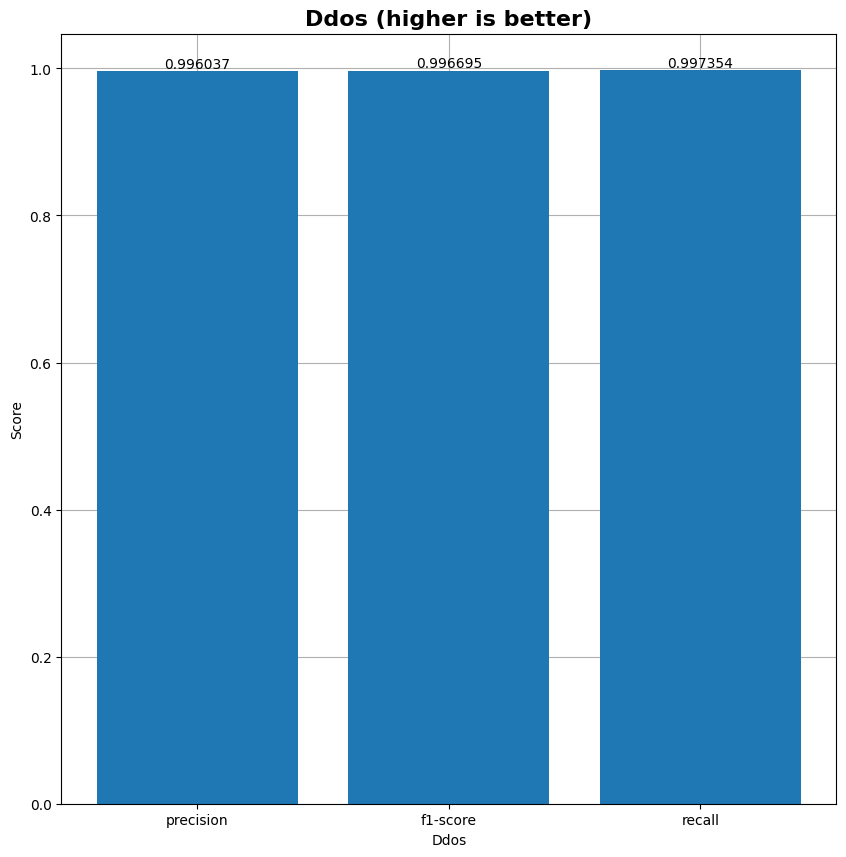

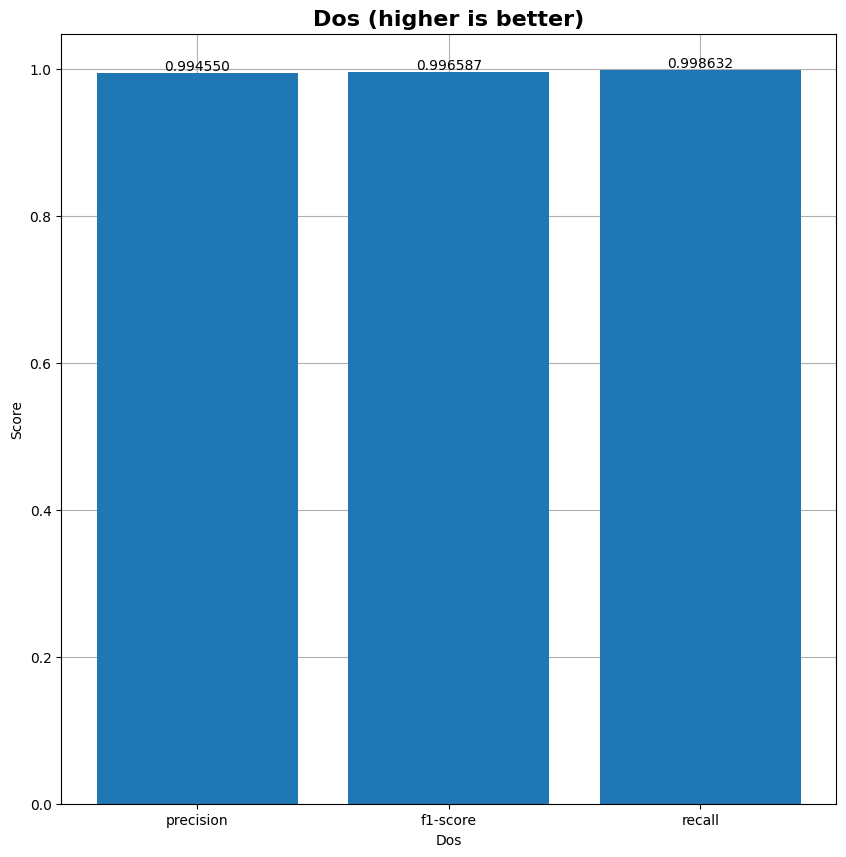

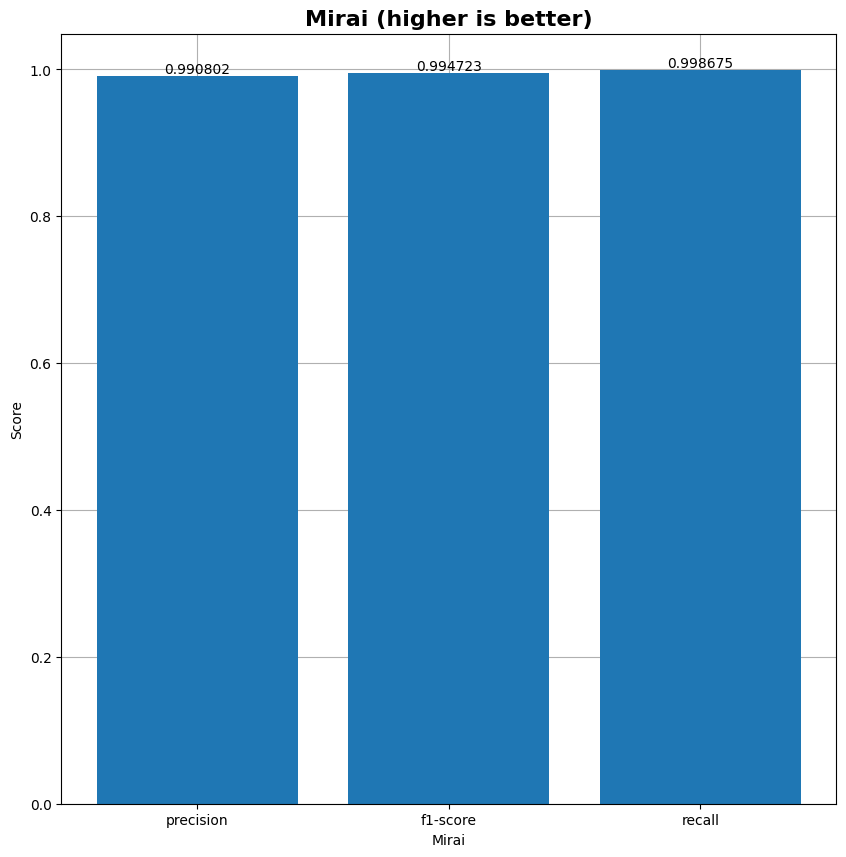

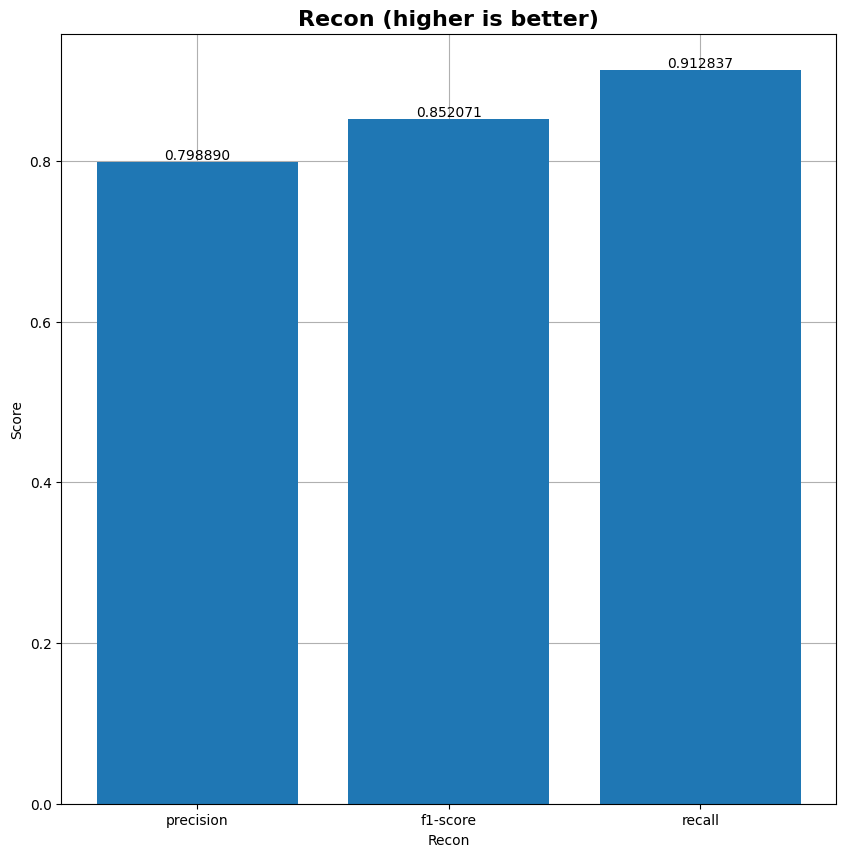

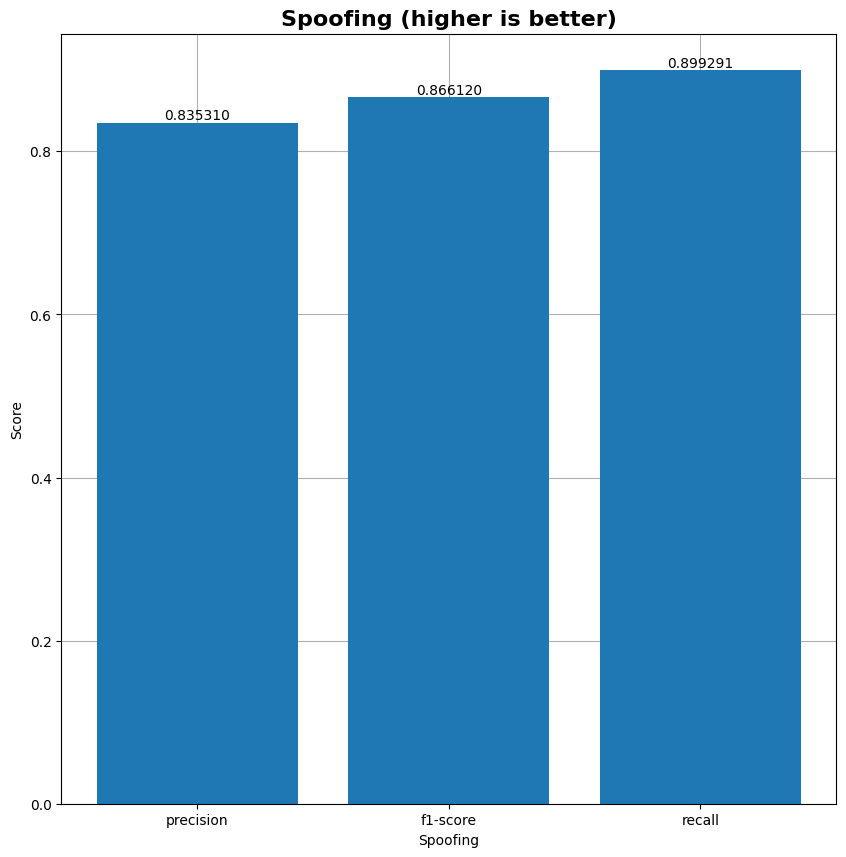

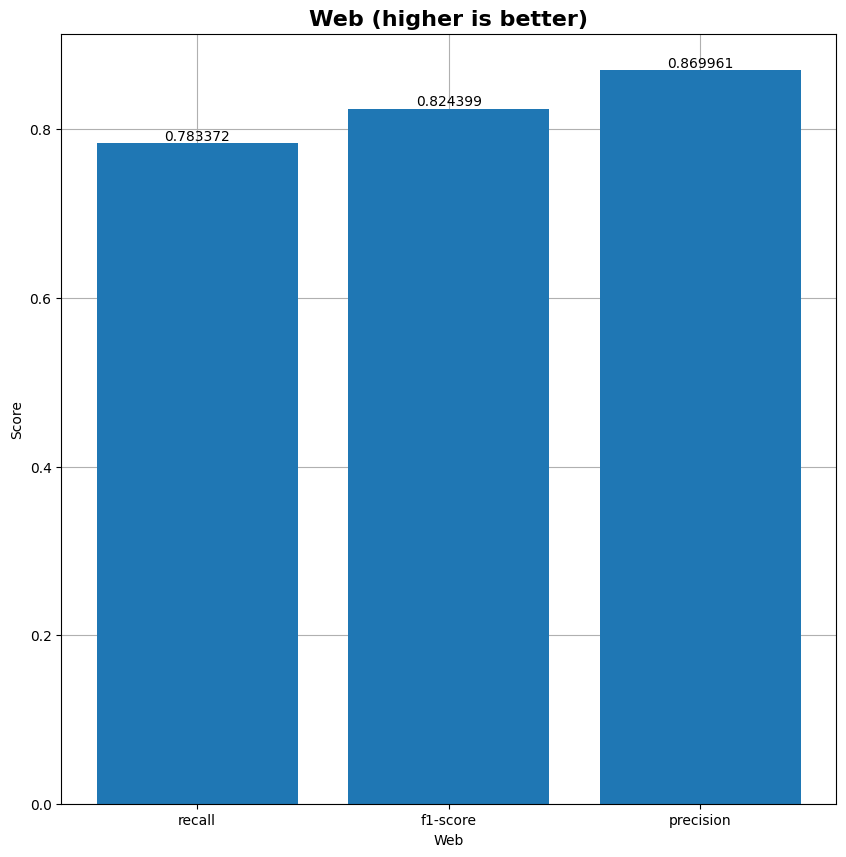

In [67]:
plot_mc(y_pred, y_test, "LightGBM")

In [68]:
model_name = "CatBoost_5000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Support Vector Machine

In [ ]:
%%time

start = time.time()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

end = time.time()

SVM_Time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(svm_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, SVM_Time]
results_dict["SVM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "SVM")

In [ ]:
model_name = "SVM_5000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [69]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((27880, 47), (27880,), (6120, 47), (6120,), (6000, 47), (6000,))

In [71]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747143880.441289   49239 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5029 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [72]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 47)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 580,312 (2.21 MB)

 Trainable params: 580,312 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1747143883.432723   55300 service.cc:152] XLA service 0x731e04009f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747143883.432737   55300 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-05-13 16:44:43.469455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747143883.702957   55300 cuda_dnn.cc:529] Loaded cuDNN version 90300


  70/1743 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5042 - loss: 1.3808    

I0000 00:00:1747143884.764085   55300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1743/1743 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8524 - loss: 0.4226 - val_accuracy: 0.9825 - val_loss: 0.0509
Epoch 2/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9874 - loss: 0.0382 - val_accuracy: 0.9910 - val_loss: 0.0224
Epoch 3/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9905 - loss: 0.0281 - val_accuracy: 0.9907 - val_loss: 0.0336
Epoch 4/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9928 - loss: 0.0252 - val_accuracy: 0.9953 - val_loss: 0.0129
Epoch 5/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9941 - loss: 0.0163 - val_accuracy: 0.9964 - val_loss: 0.0109
Epoch 6/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9940 - loss: 0.0182 - val_accuracy: 0.9946 - val_loss: 0.0165
Epoch 7/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9938 - loss: 0.0241 - val_accuracy: 0.9953 - val_loss: 0.0111
Epoch 8/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accurac

In [74]:
y_pred = np.argmax(y_pred, axis=1)

In [75]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9943 - loss: 0.0331   


In [76]:
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [77]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, FFNN_Time]
results_dict["FF-NN"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [78]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707
XGBoost,0.909500,0.911307,0.909682,0.909500,0.896765,0.363833,1.874167,1.369002,0.029147,3.904210
LightGBM,0.910500,0.912470,0.910583,0.910500,0.897959,0.359667,1.849667,1.360025,0.077371,2.129981
CatBoost,0.907500,0.910157,0.907818,0.907500,0.894562,0.371500,1.918833,1.385220,0.089468,25.470413
FF-NN,0.994167,0.994173,0.994165,0.994167,0.993334,0.006000,0.006333,0.079582,0.337137,91.407913


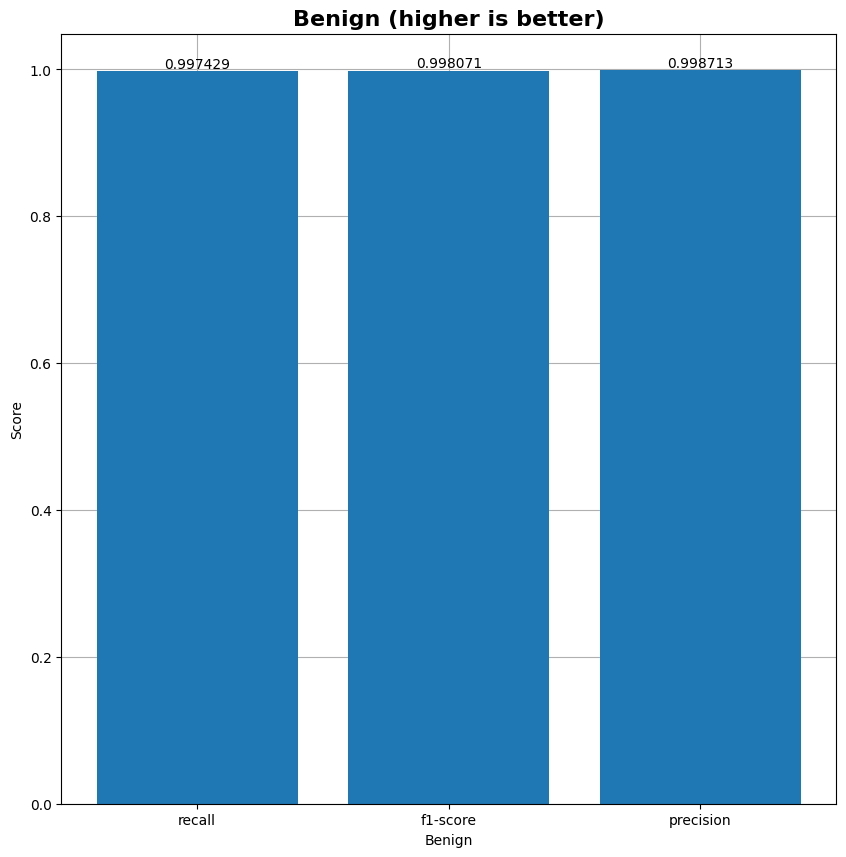

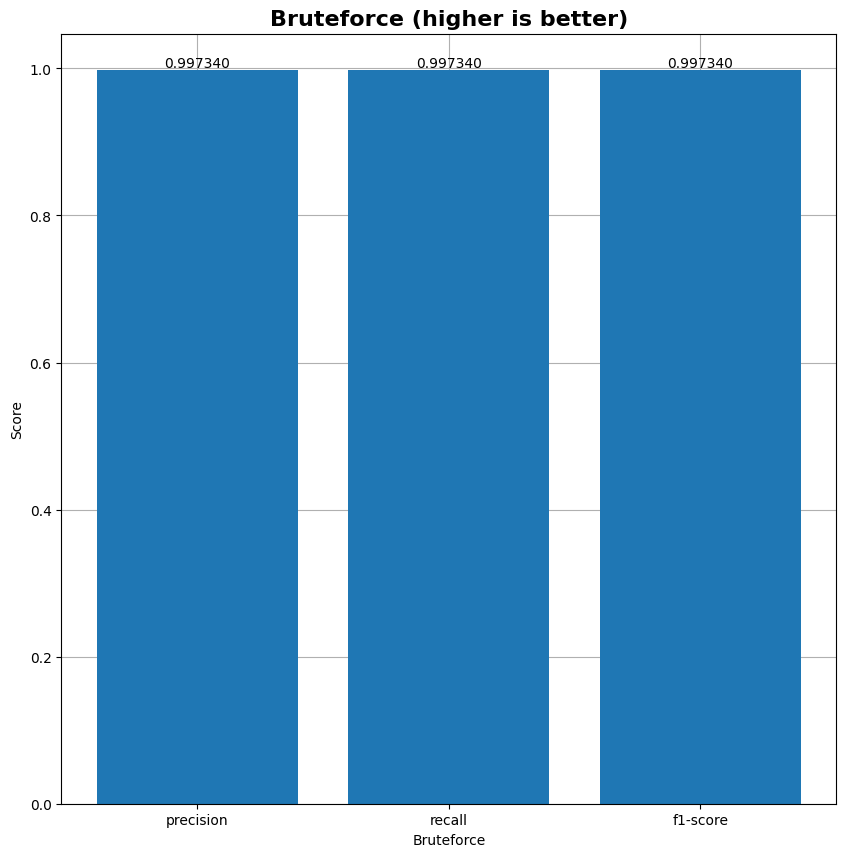

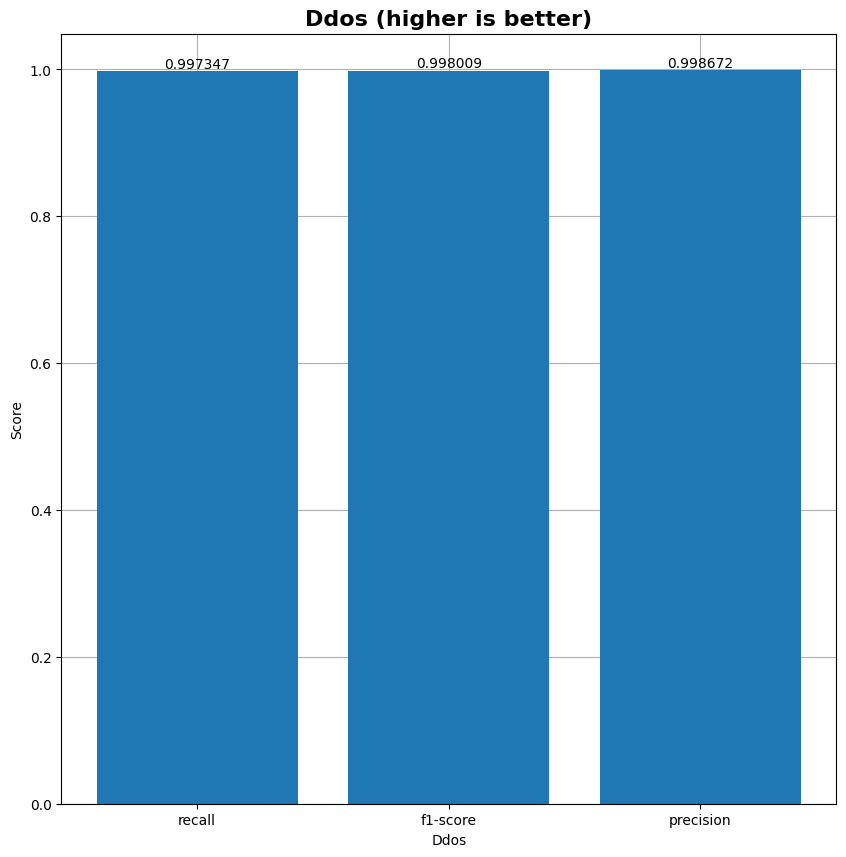

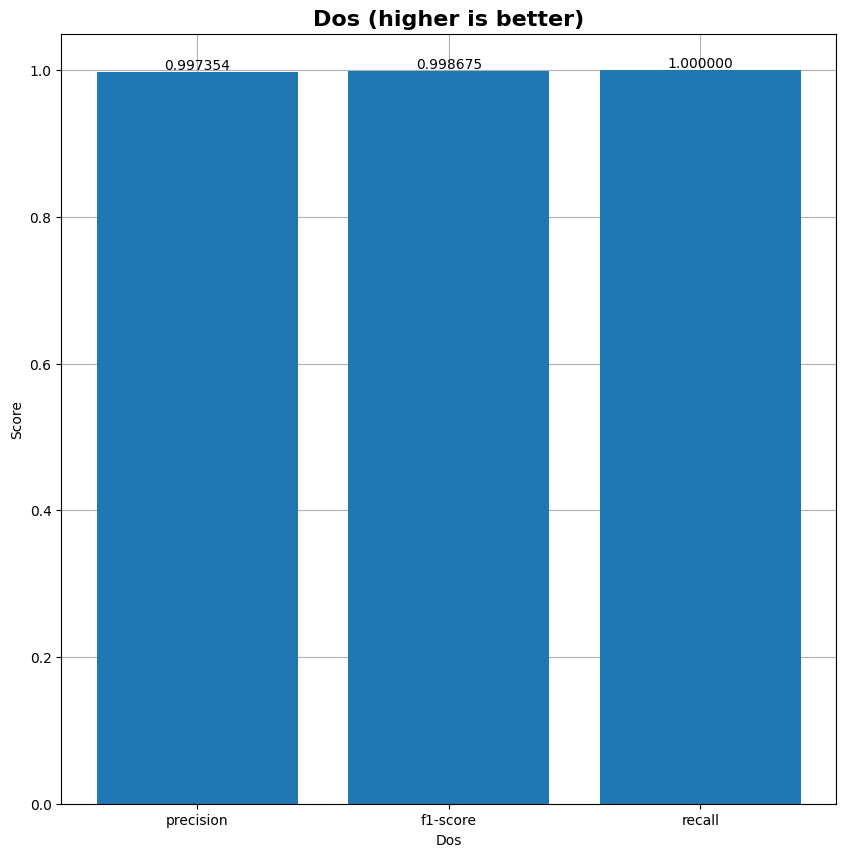

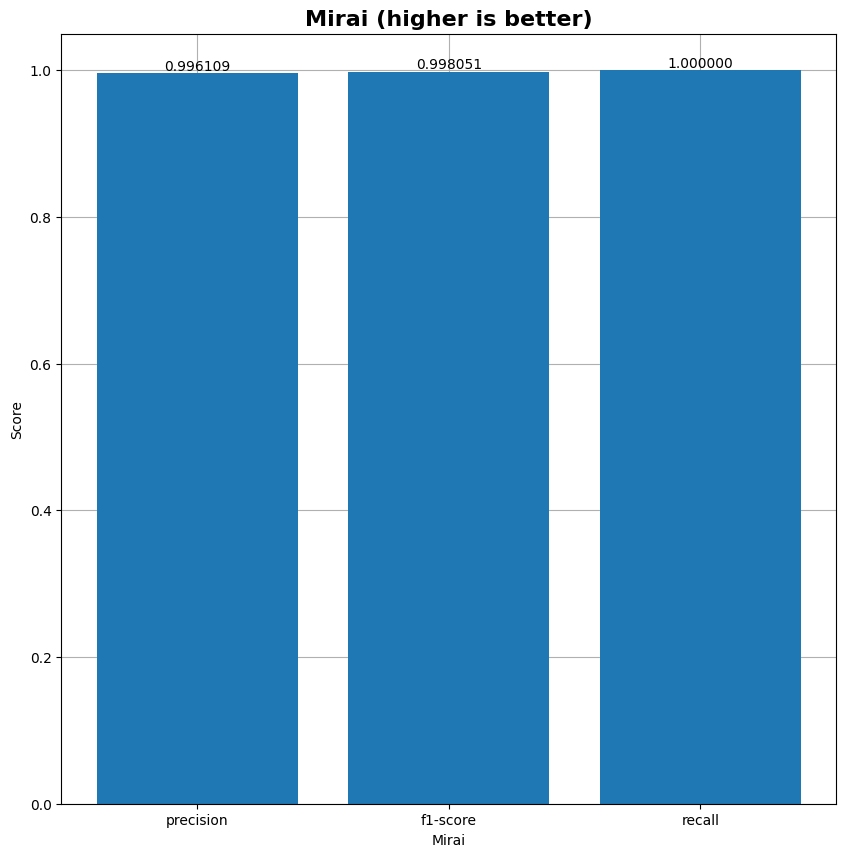

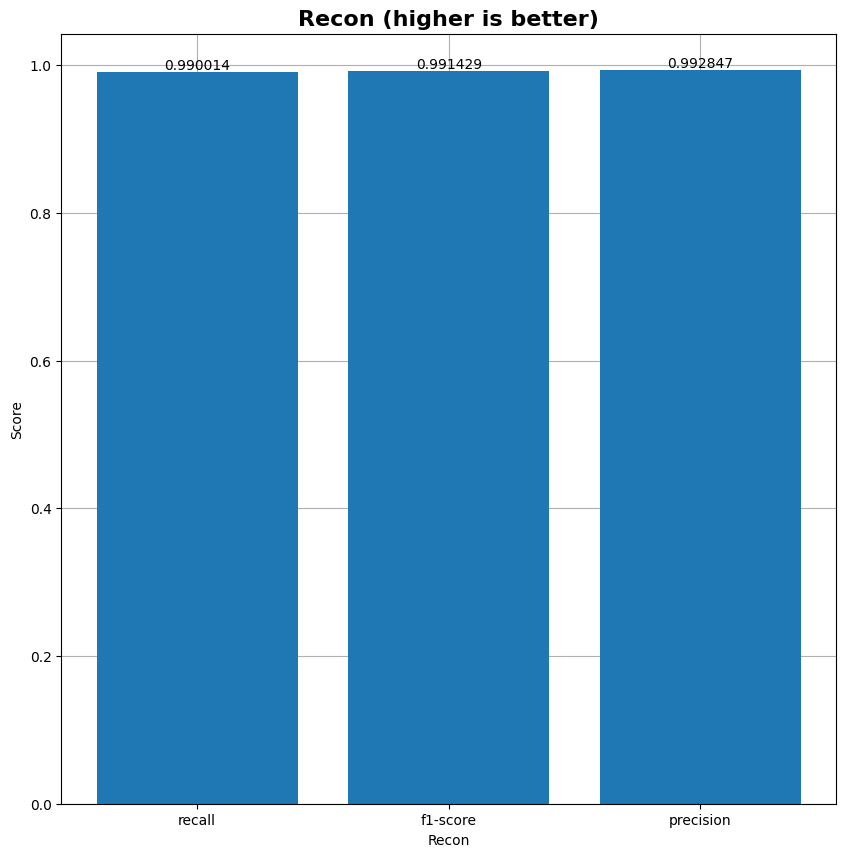

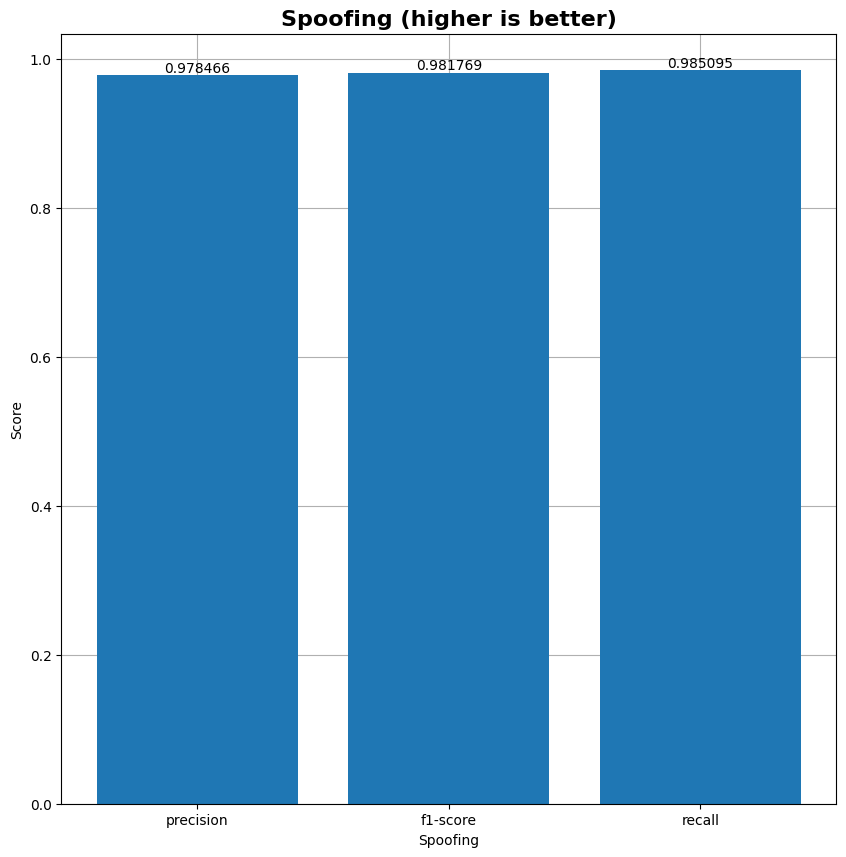

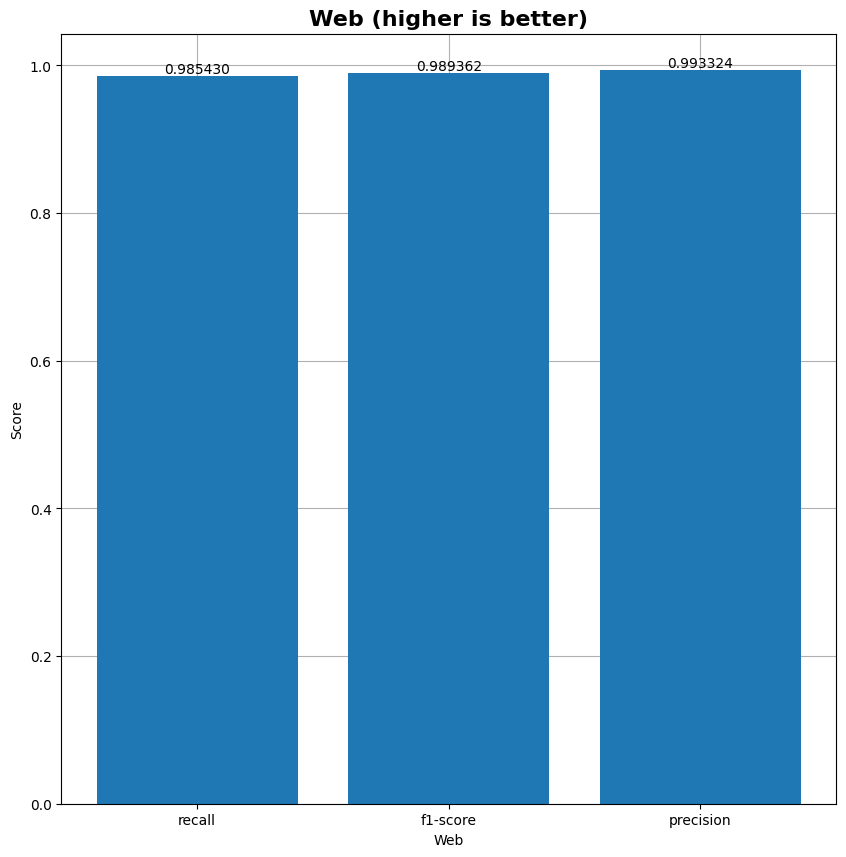

In [79]:
plot_mc(y_pred, y_test, "FF-NN")

In [80]:
model_name = "FFNN_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Create sequences

Create sequences for LSTM and GRU RNN variants

In [81]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [82]:
num_components = len(np.unique(y))

In [83]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

# LSTM

In [84]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [85]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [86]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [87]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,720 (170.78 KB)

 Trainable params: 43,720 (170.78 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9051 - loss: 0.3663 - val_accuracy: 0.9992 - val_loss: 0.0056
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9989 - loss: 0.0096 - val_accuracy: 0.9990 - val_loss: 0.0064
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9979 - loss: 0.0094 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9997 - val_loss: 0.0032
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9995 - loss: 0.0034 - val_accuracy: 0.9997 - val_loss: 0.0031
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 0.0030
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.

In [89]:
_, accuracy = model.evaluate(X_test, y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0035     


In [90]:
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [91]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [92]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [93]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LSTM_Time]
results_dict["LSTM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [94]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707
XGBoost,0.909500,0.911307,0.909682,0.909500,0.896765,0.363833,1.874167,1.369002,0.029147,3.904210
LightGBM,0.910500,0.912470,0.910583,0.910500,0.897959,0.359667,1.849667,1.360025,0.077371,2.129981
CatBoost,0.907500,0.910157,0.907818,0.907500,0.894562,0.371500,1.918833,1.385220,0.089468,25.470413
FF-NN,0.994167,0.994173,0.994165,0.994167,0.993334,0.006000,0.006333,0.079582,0.337137,91.407913
LSTM,0.999500,0.999501,0.999500,0.999500,0.999428,0.002001,0.009338,0.096633,0.508968,65.348346


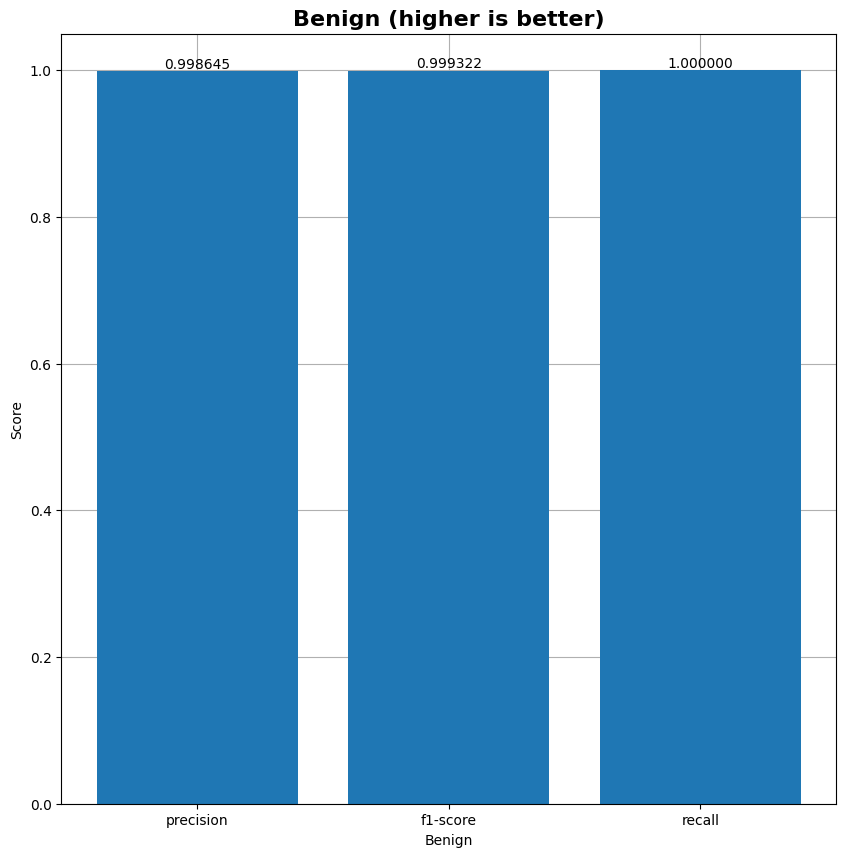

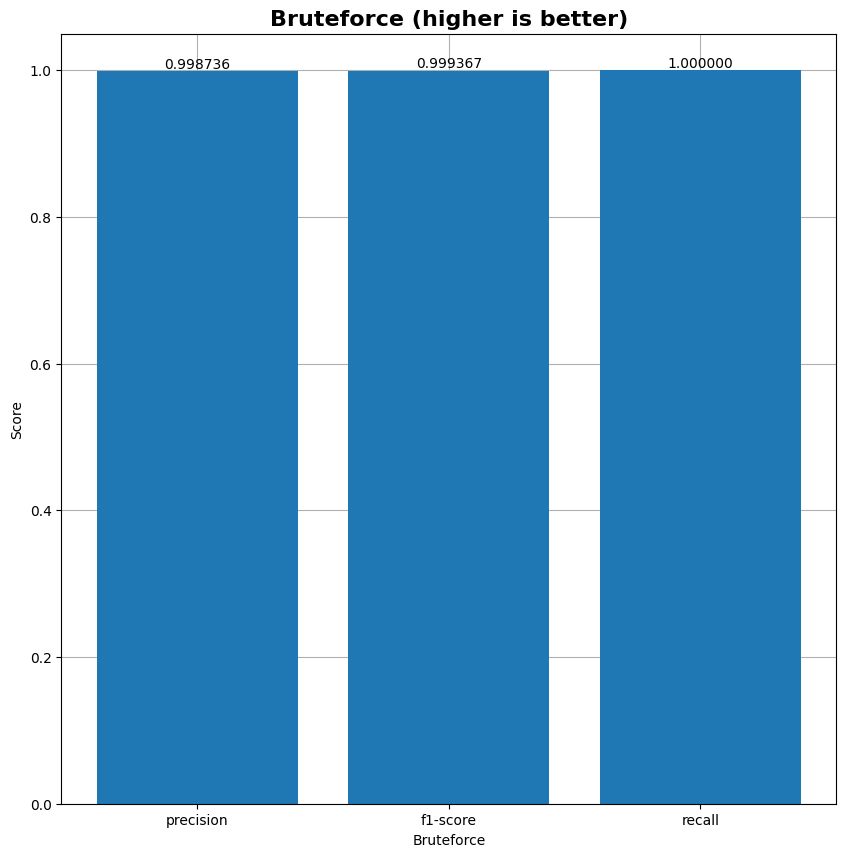

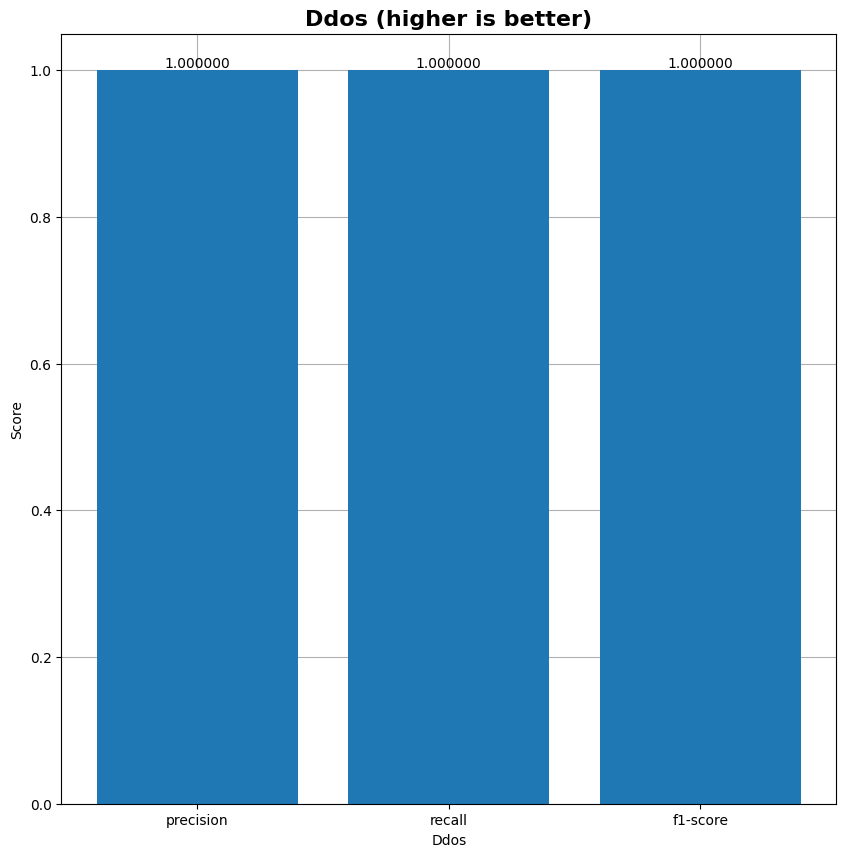

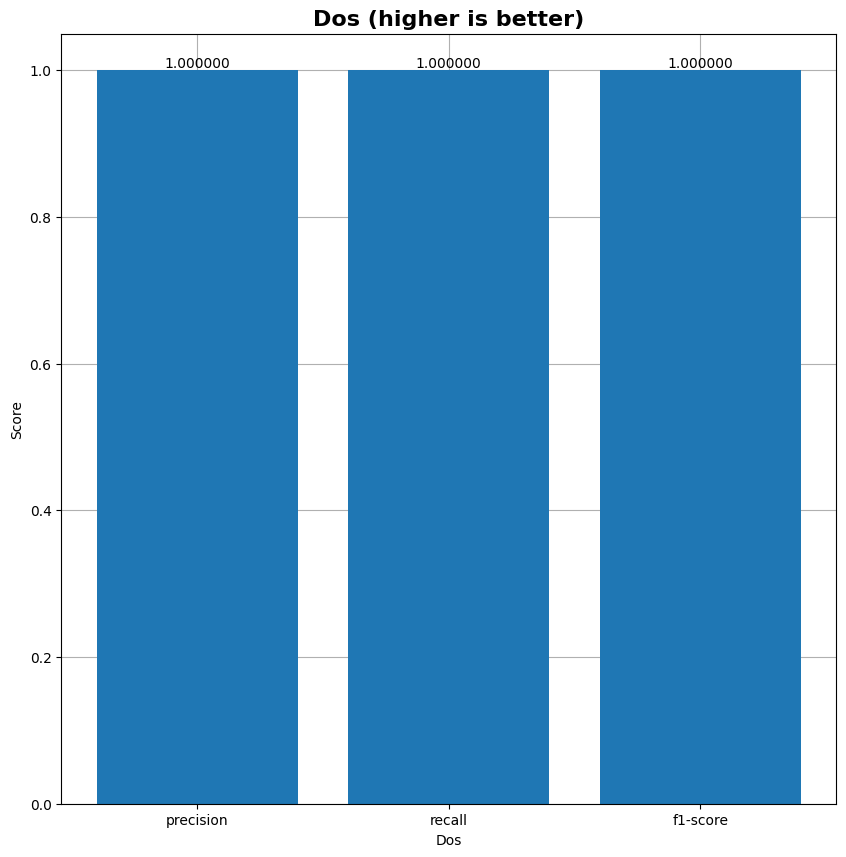

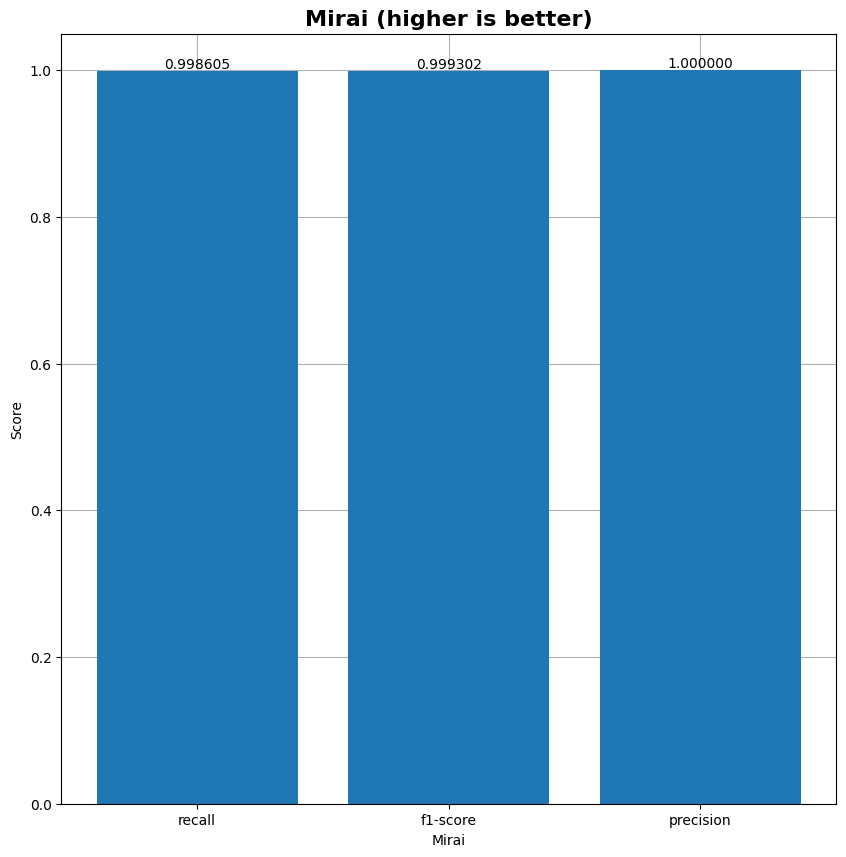

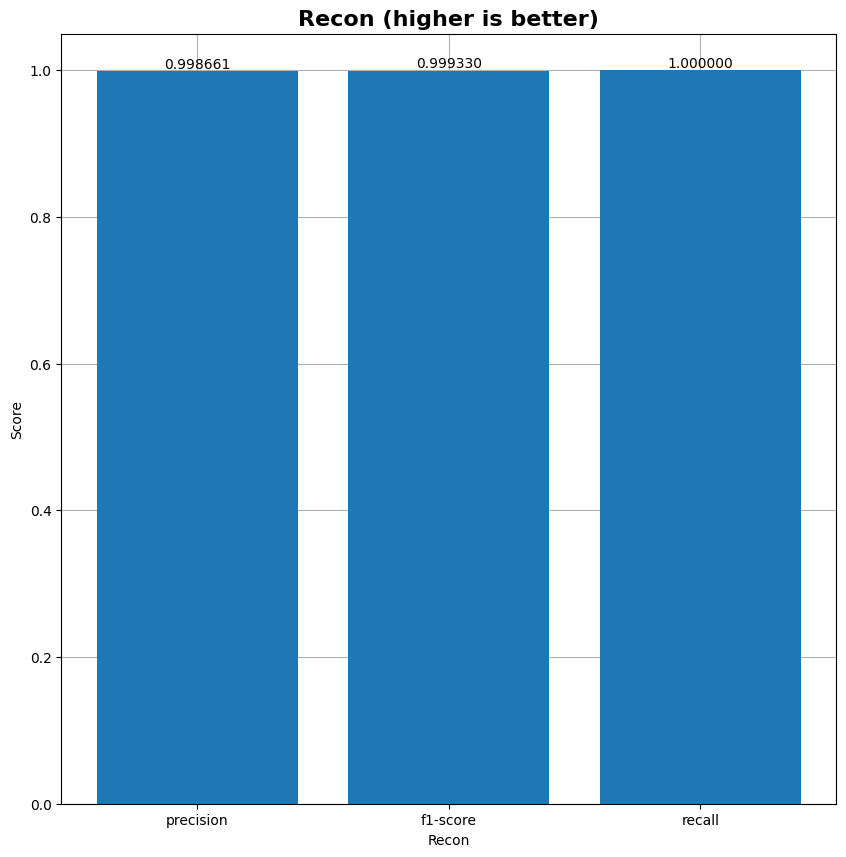

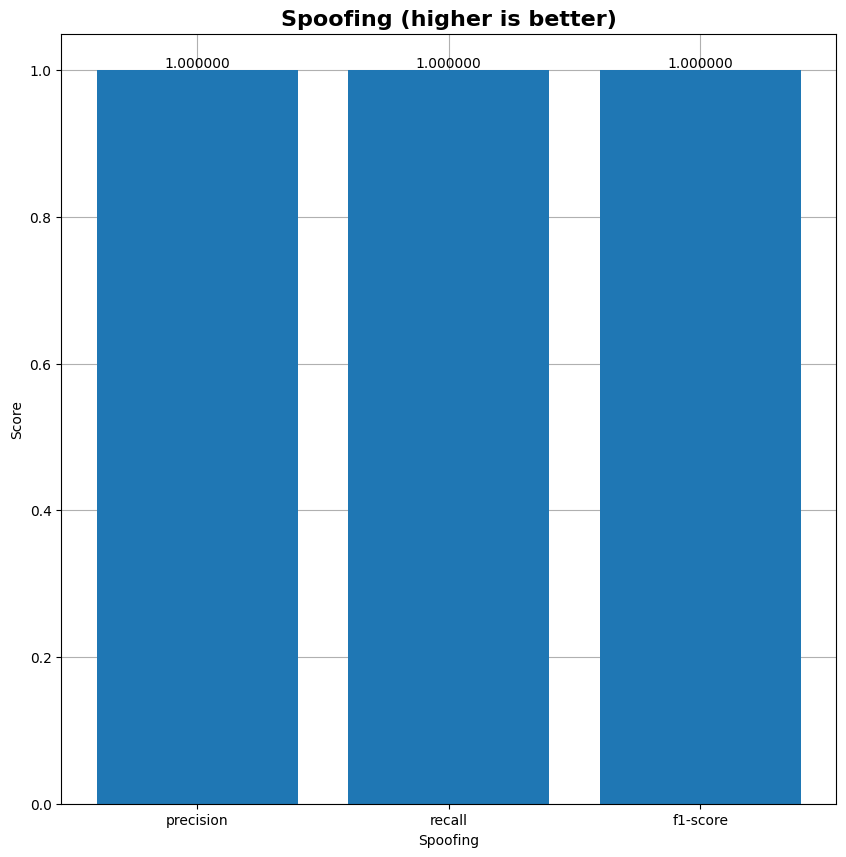

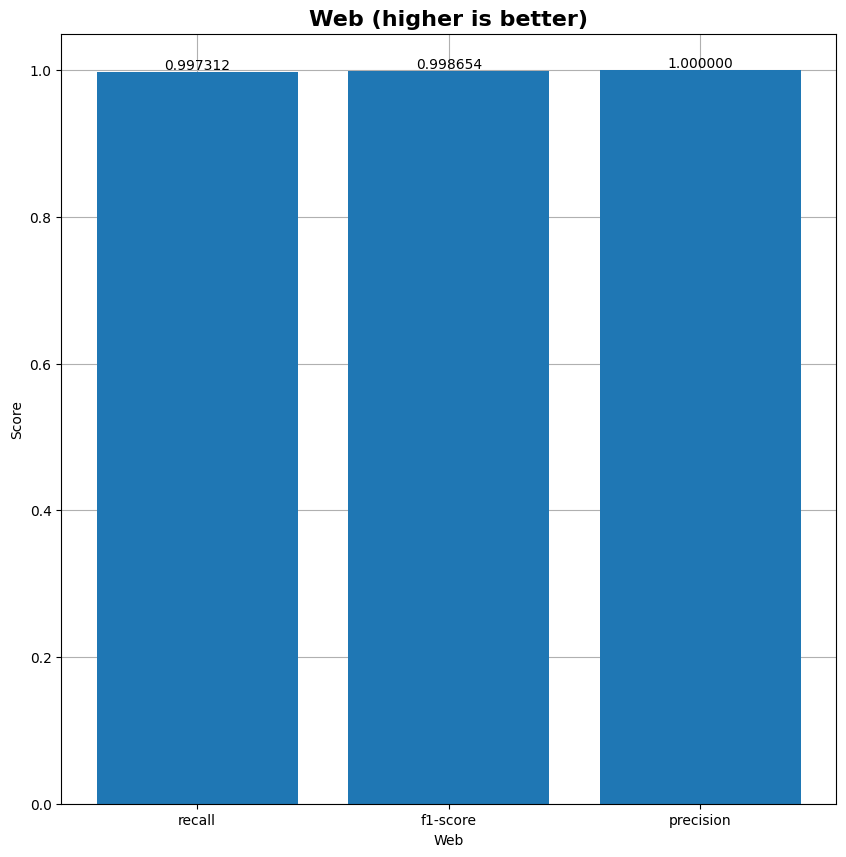

In [95]:
plot_mc(y_pred, y_test, "LSTM")

In [96]:
model_name = "LSTM_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# GRU

In [97]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [98]:
def create_model_GRU(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.GRU(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.GRU(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='sigmoid')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [99]:
# Build model
model = create_model_GRU(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 64)         │        21,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,736 (131.78 KB)

 Trainable params: 33,736 (131.78 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

GRU_Time = end - start

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9103 - loss: 0.3548 - val_accuracy: 0.9995 - val_loss: 0.0039
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9993 - loss: 0.0062 - val_accuracy: 0.9990 - val_loss: 0.0047
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9997 - val_loss: 0.0029
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9997 - val_loss: 0.0033
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9995 - val_loss: 0.0038
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 0.0030
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9995 - val_loss: 0.0033
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.

In [102]:
_, accuracy = model.evaluate(X_test, y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9996 - loss: 0.0046     


In [103]:
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [104]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [105]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [106]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, GRU_Time]
results_dict["GRU"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [107]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.704833,0.711286,0.705145,0.704833,0.663654,1.114167,5.739500,2.395725,0.352871,0.507992
NB,0.529500,0.747240,0.502184,0.529500,0.513249,1.902167,10.655167,3.264225,0.008932,0.039706
RF,0.892333,0.895613,0.892693,0.892333,0.877314,0.421500,2.150500,1.466458,0.049597,2.046707
XGBoost,0.909500,0.911307,0.909682,0.909500,0.896765,0.363833,1.874167,1.369002,0.029147,3.904210
LightGBM,0.910500,0.912470,0.910583,0.910500,0.897959,0.359667,1.849667,1.360025,0.077371,2.129981
CatBoost,0.907500,0.910157,0.907818,0.907500,0.894562,0.371500,1.918833,1.385220,0.089468,25.470413
FF-NN,0.994167,0.994173,0.994165,0.994167,0.993334,0.006000,0.006333,0.079582,0.337137,91.407913
LSTM,0.999500,0.999501,0.999500,0.999500,0.999428,0.002001,0.009338,0.096633,0.508968,65.348346
GRU,0.999667,0.999667,0.999667,0.999666,0.999619,0.001334,0.006670,0.081670,0.496015,64.164945


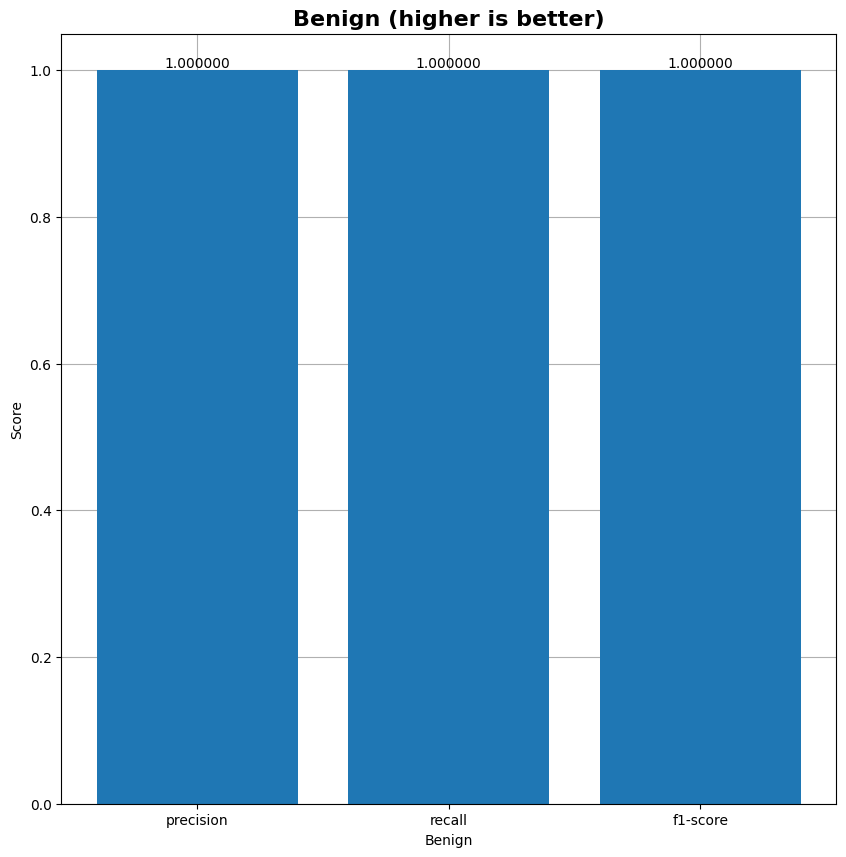

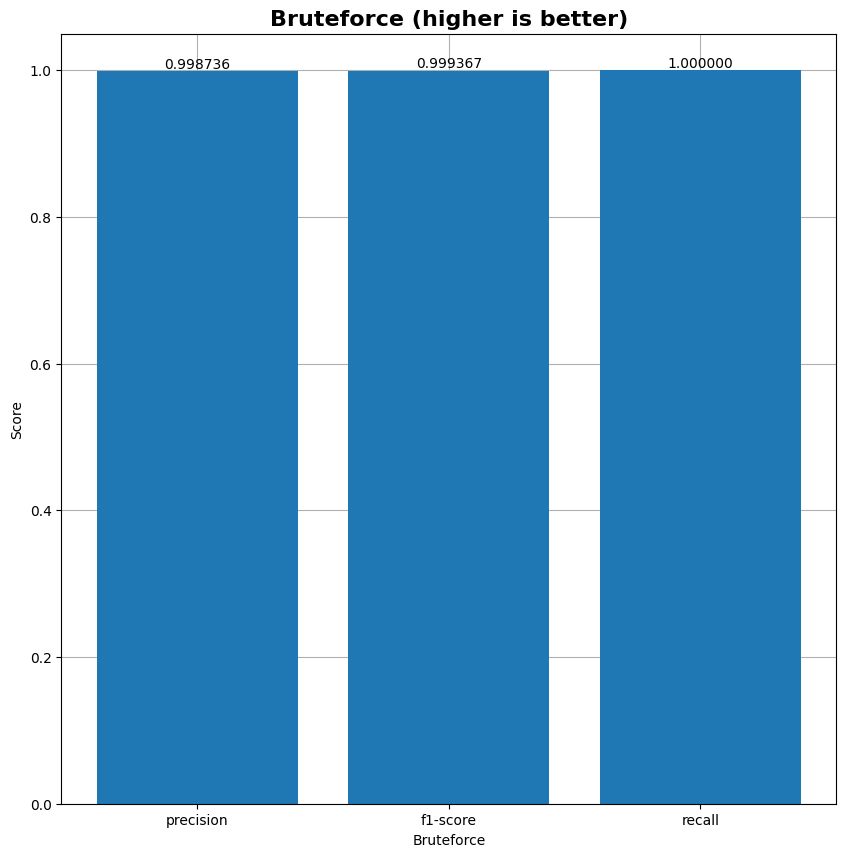

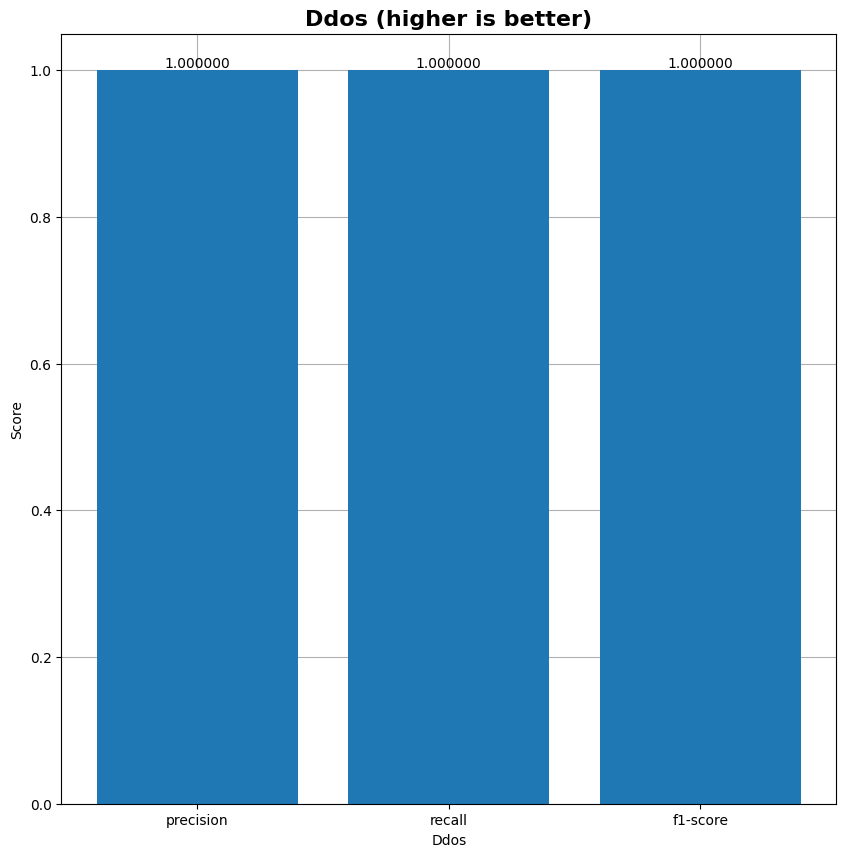

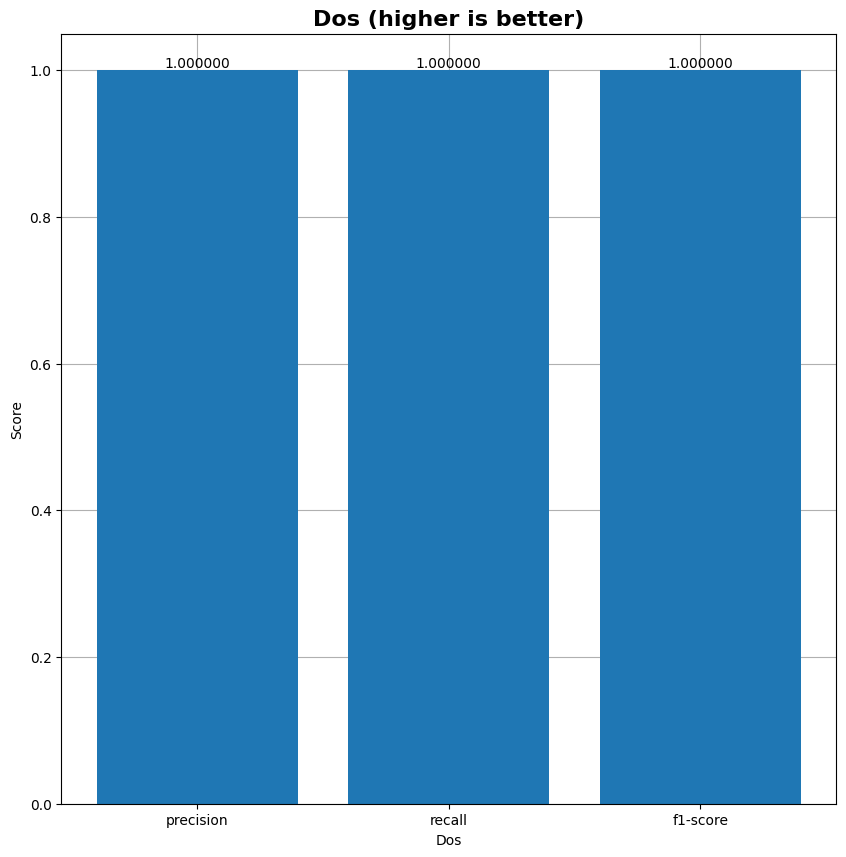

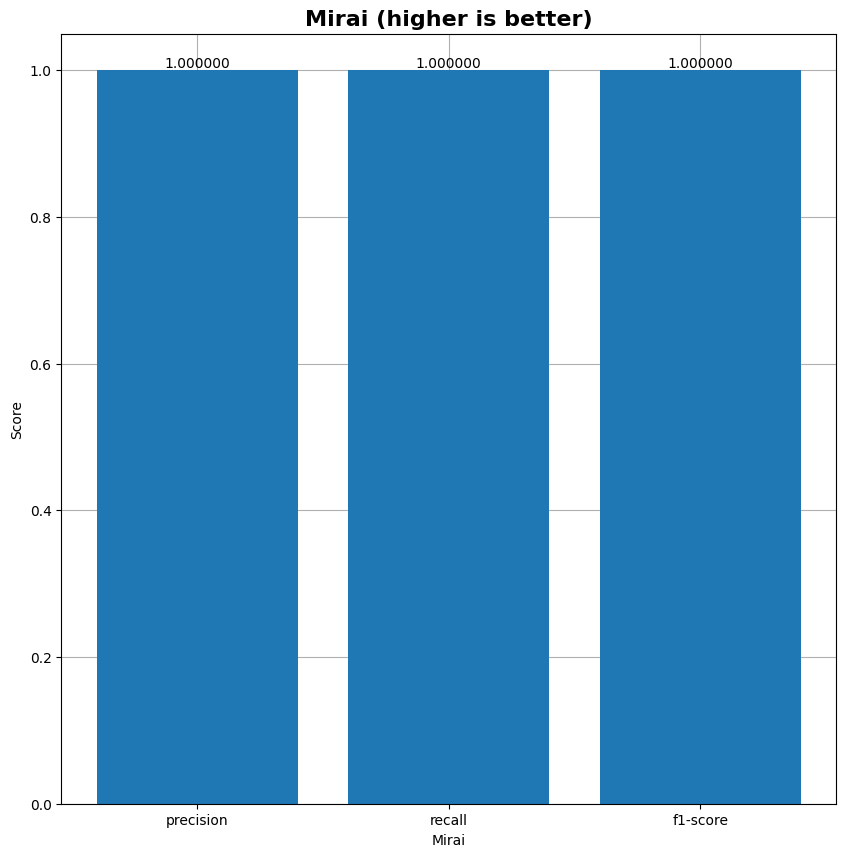

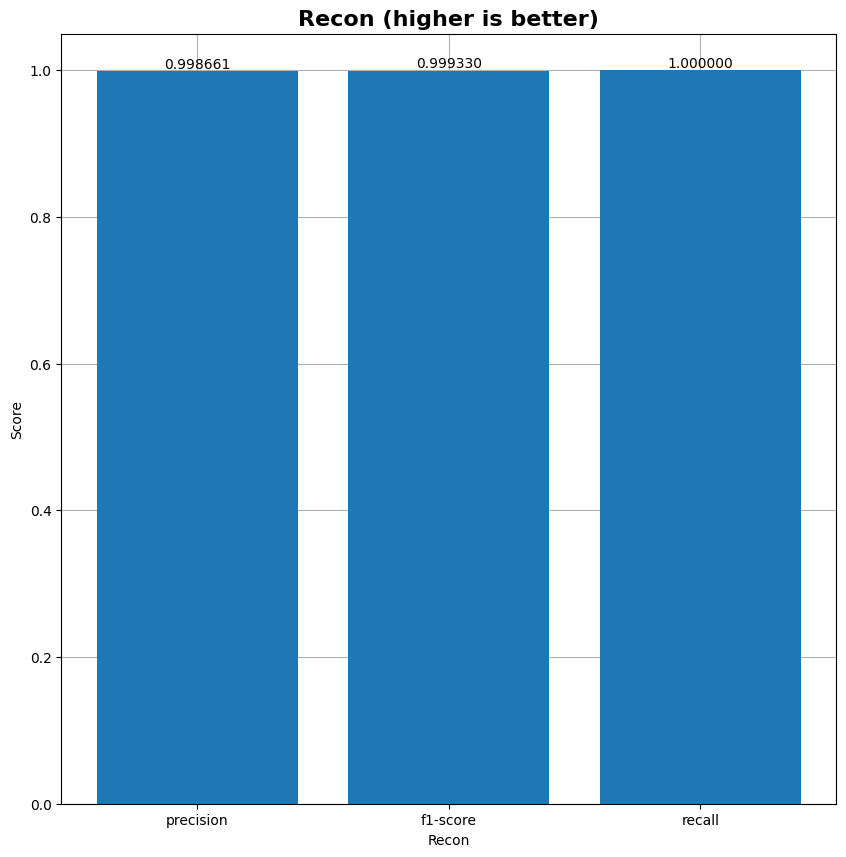

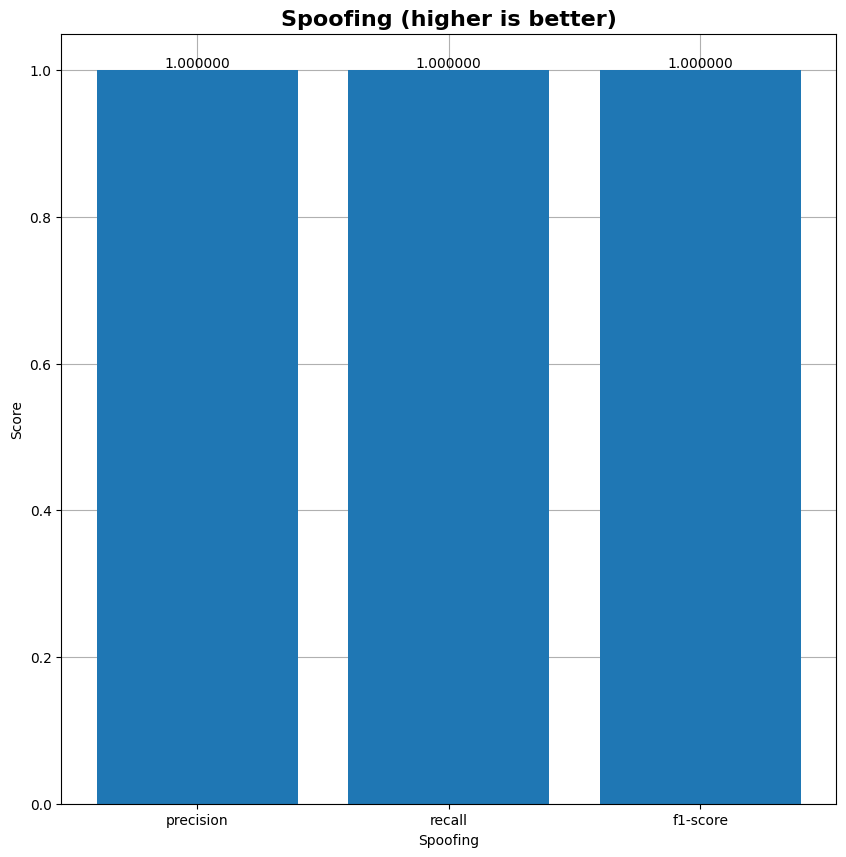

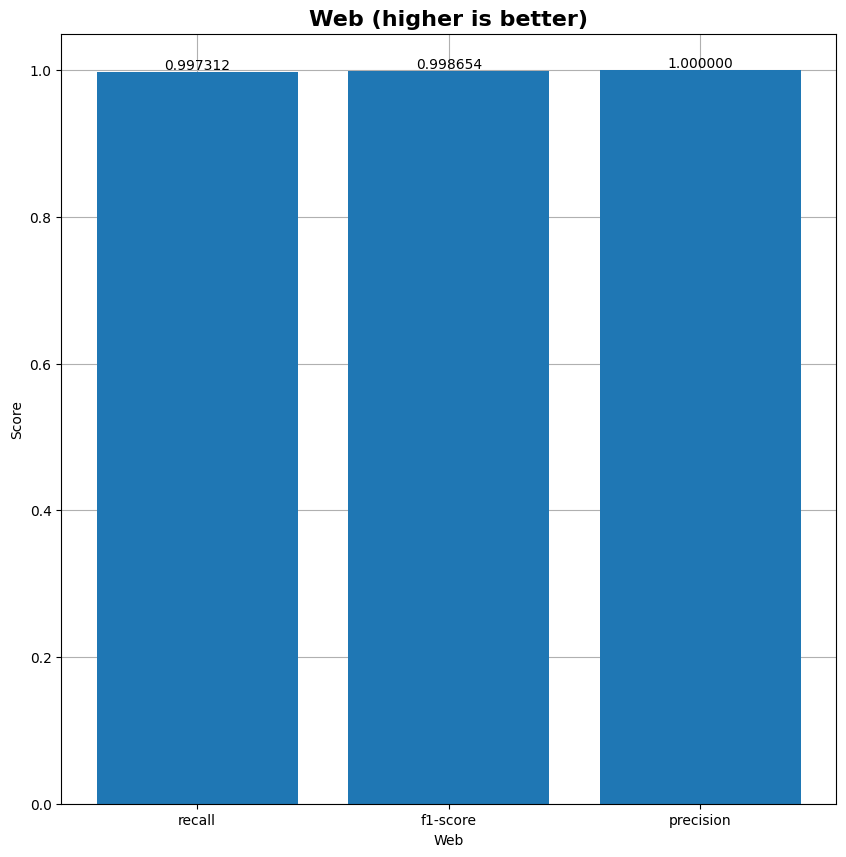

In [108]:
plot_mc(y_pred, y_test, "GRU")

In [109]:
model_name = "GRU_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

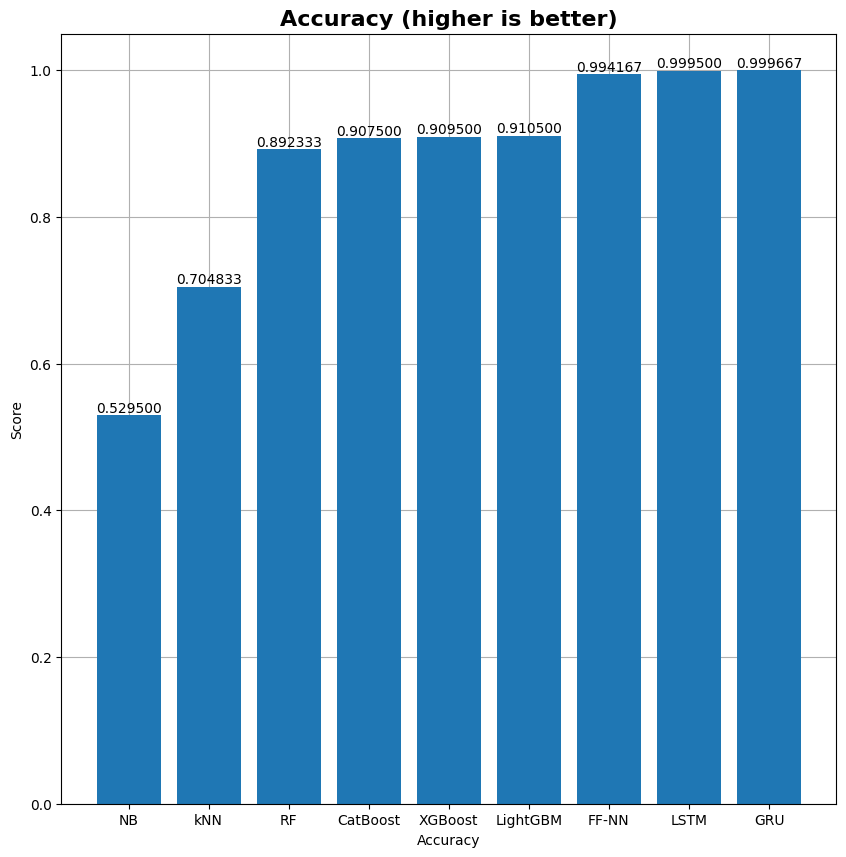

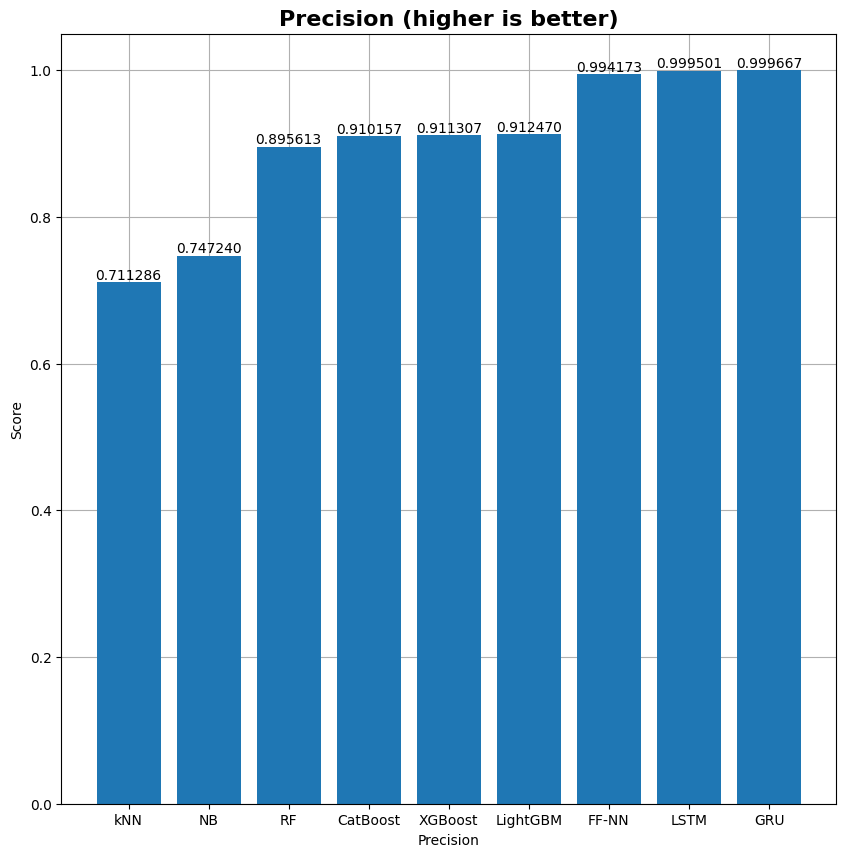

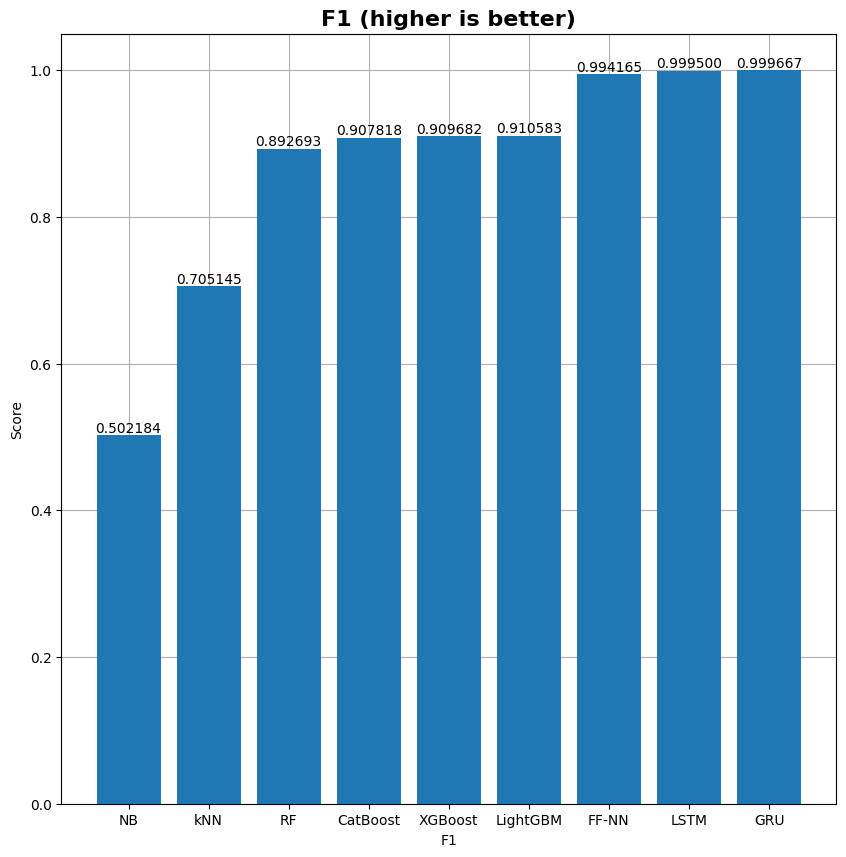

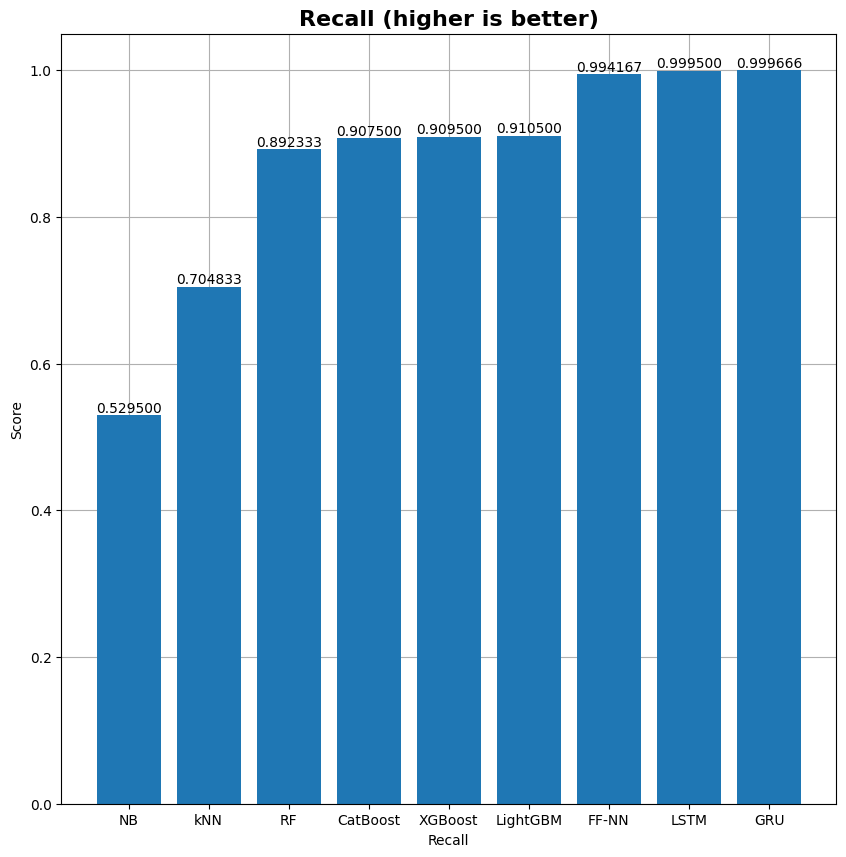

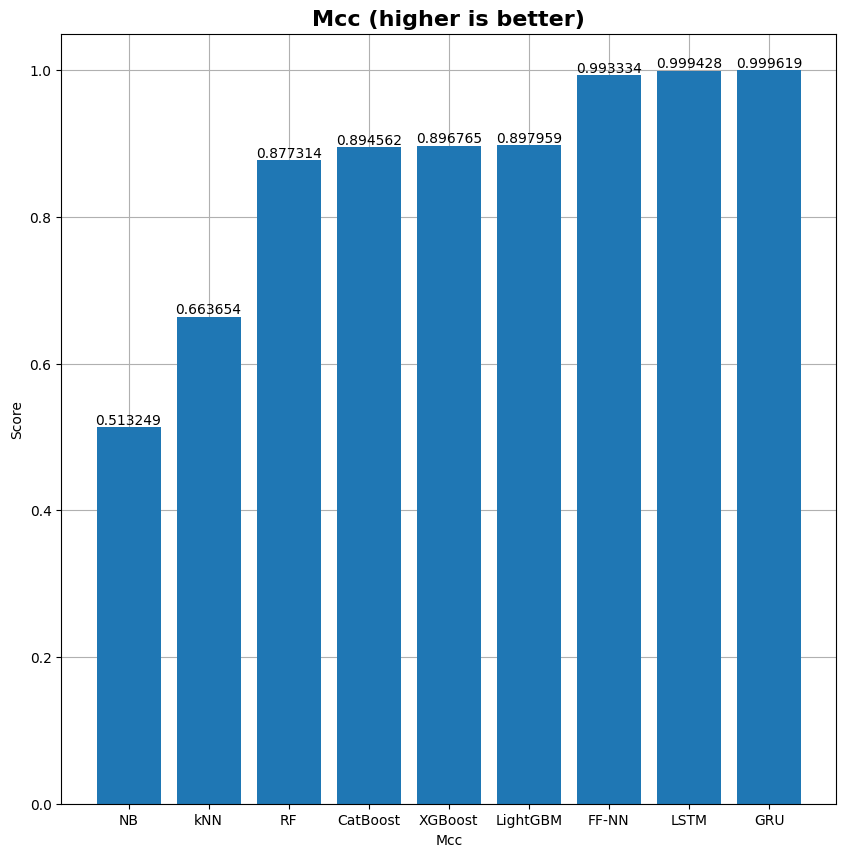

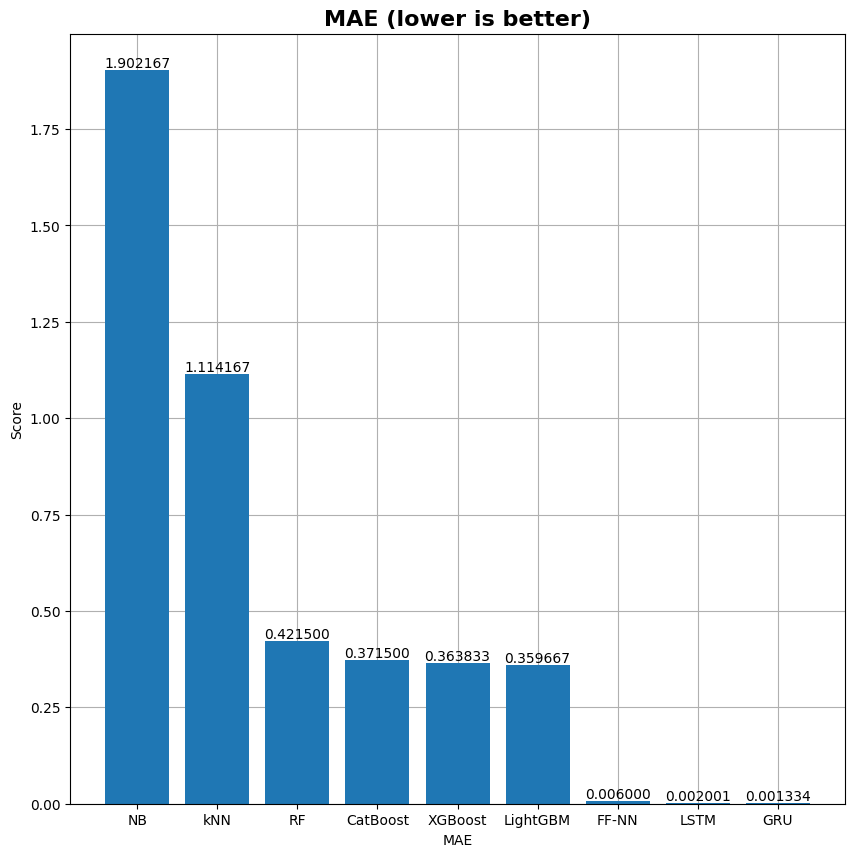

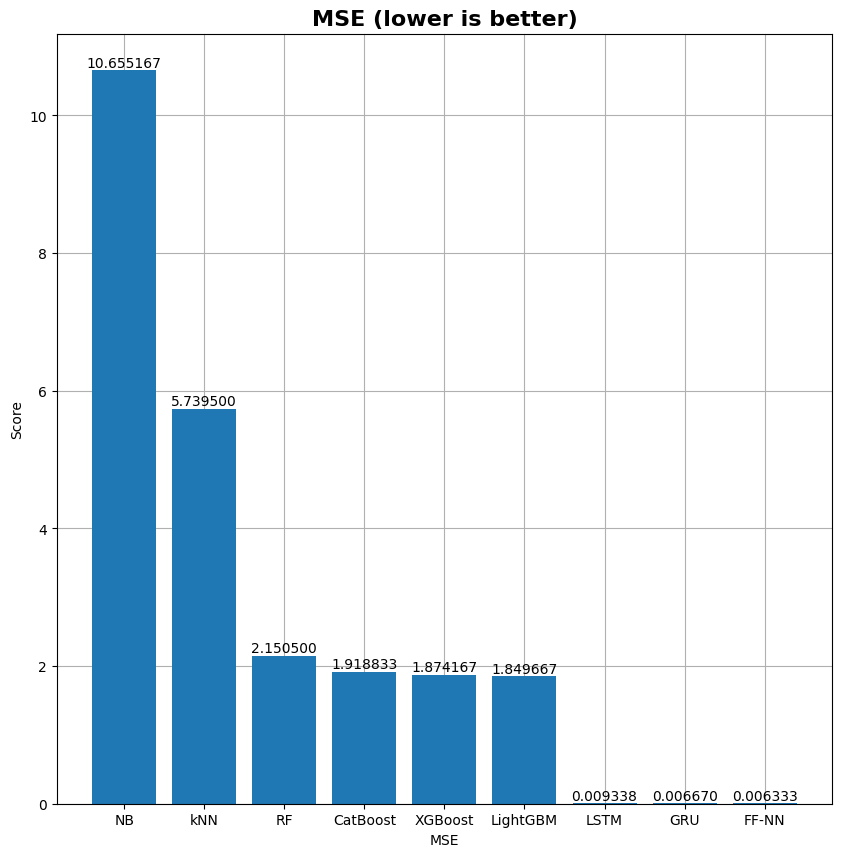

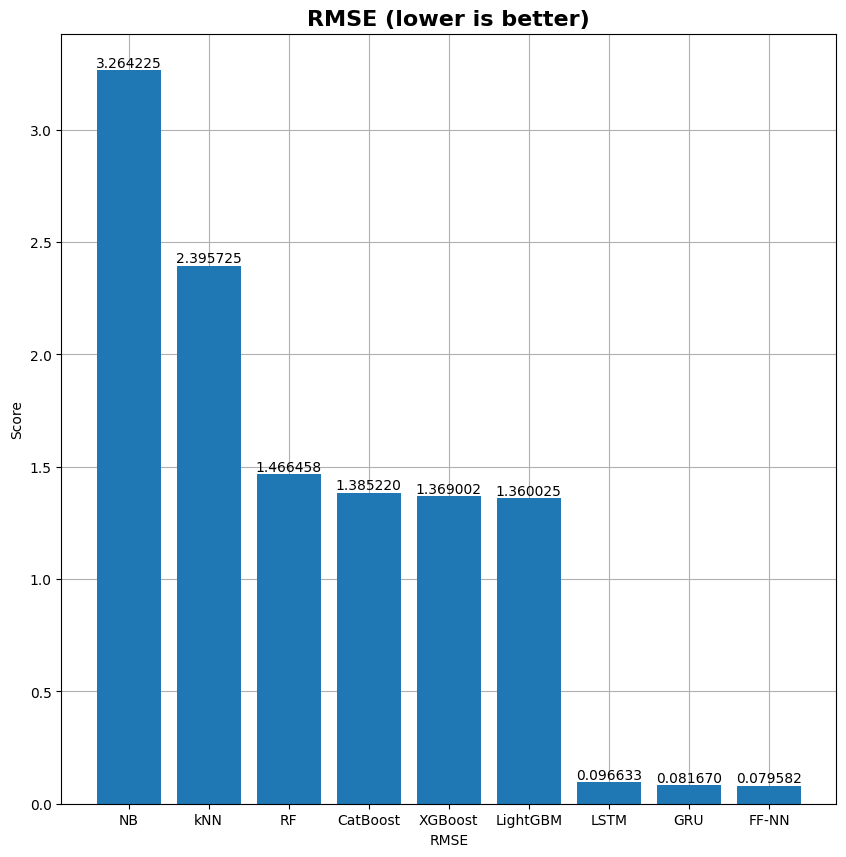

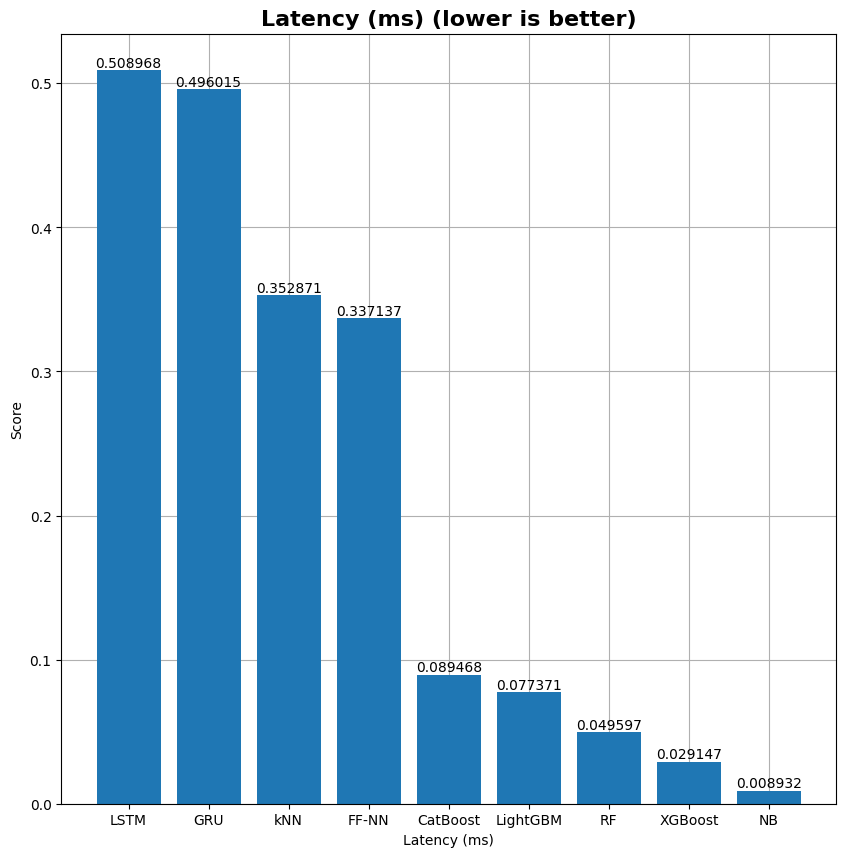

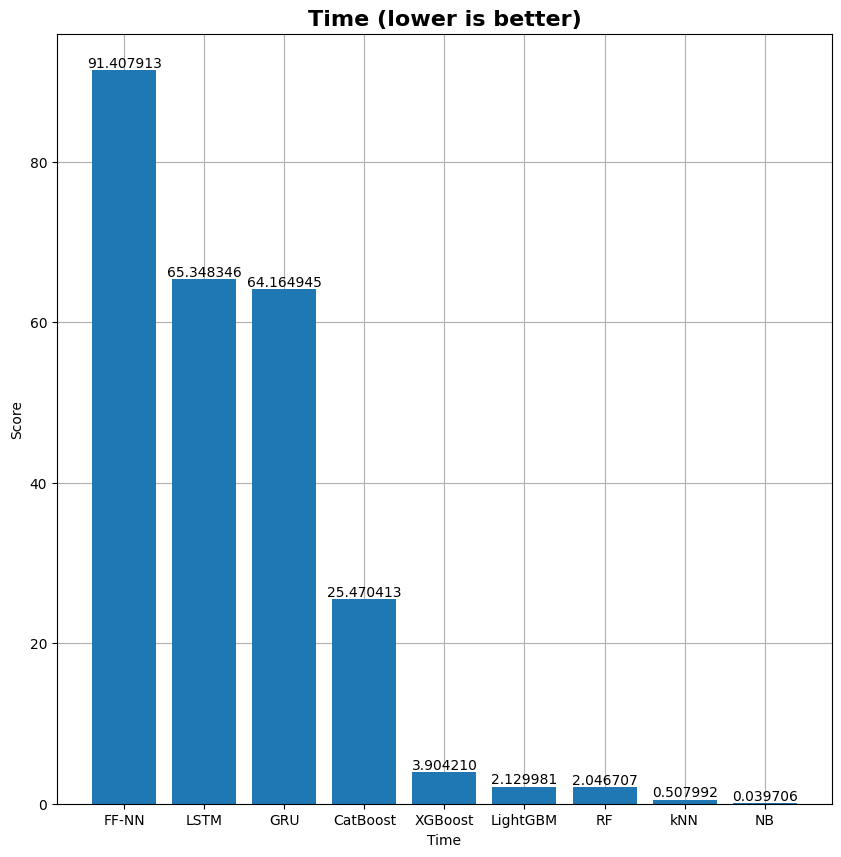

In [110]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")